# Load libraries 

In [1]:
library(ggplot2) ##plotting package
library(cowplot) ##plots + arrange plots etc
library(factoextra) ##plot, PC plots .etc
library(RColorBrewer) ## color palettes
library(dplyr) ## for the R pipes
library(tidyr) ## for tidying the dataframes

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Functions for processing 

## TPM

In [2]:
tpm <- function(feature_counts, input_raw=0) {
    
    #' calculate tpms for two dependent counts
    #' 
    #' @description This function will calculate tpms for counts tables  
    #' 
    #' @param feature_counts paths counts
    #'
    #' @usage tpm(feature_counts)
    #' @return A dataframe with tpms values
    #' @export
    #' @importFrom base paste
    
    if (input_raw==0) {
        #load counts .txt table
        print(paste("Processing ----> ", feature_counts))
        counts_tab <- read.table(feature_counts, head=TRUE)

        #get number of columns
        n_samples <- ncol(counts_tab)
        print(n_samples)

        #get only the counts columns
        counts <- as.matrix(counts_tab[c(7:n_samples)])/counts_tab$Length
        print(head(counts))

        #calculate TPMs
        tpm_mat <- t( t(counts) * 1e6 / colSums(counts) )
        tpm_df <- as.data.frame(tpm_mat) 
        print(head(tpm_df))

        #get column ids
        colnames_id <- nrow(as.data.frame(strsplit(colnames(tpm_df), '\\.'))[1]) - 1
        print(colnames_id)

        new_colnames <- as.character(lapply(strsplit(colnames(tpm_df), '\\.'), `[`, colnames_id))
        print(new_colnames)

        colnames(tpm_df) <- new_colnames
        rownames(tpm_df) <- counts_tab$Geneid

        print(paste("Number of bidirectionals = ", nrow(tpm_df)))
        print("DONE!")

        return(tpm_df)   
        } else {
        
        print(paste("Processing ----> ", feature_counts))
        
        counts_tab <- feature_counts
        
        #get number of columns
        n_samples <- ncol(counts_tab)
        print(n_samples)

        #get only the counts columns
        counts <- as.matrix(counts_tab[c(7:n_samples)])/counts_tab$Length
        print(head(counts))

        #calculate TPMs
        tpm_mat <- t( t(counts) * 1e6 / colSums(counts) )
        tpm_df <- as.data.frame(tpm_mat) 
        print(head(tpm_df))

        #get column ids
        colnames_id <- nrow(as.data.frame(strsplit(colnames(tpm_df), '\\.'))[1]) - 1
        print(colnames_id)

        new_colnames <- as.character(lapply(strsplit(colnames(tpm_df), '\\.'), `[`, colnames_id))
        print(new_colnames)

        colnames(tpm_df) <- new_colnames
        rownames(tpm_df) <- counts_tab$Geneid

        print(paste("Number of bidirectionals = ", nrow(tpm_df)))
        print("DONE!")
        return(tpm_df)  

    }
  
}

In [3]:
tpm_calculation <- function(count_g,len_g) {
    
    #' calculate tpms for two dependent counts #https://support.bioconductor.org/p/91218/
    #' 
    #' @description This function will calculate tpms for counts table
    #' derived from the same library.  
    #' 
    #' @param count_g data.frame. first counts
    #' 
    #' @param len_g list of integers. Transcript lengths corresponding to count_g
    #' 
    #'
    #' @usage tpm(count_g, len_g)
    #' @return Matix with tpms values for genes in data.frame
    #' @export

    
  g <- count_g/len_g

  tot_tpms <- colSums(g)
  
  tpm_g <- t(t(g)*1e6/tot_tpms)
 
    
  return(tpm_g)   
  
}

## Summary statistics for counts

In [4]:
cal_summary_stats <- function(dataframe, num_samples) {
        
    #' return summary statistics such as mean, median, variance etc 
    #' for counts matrix in SAF format
    #' 
    #' @description This function will calculate tpms for counts table
    #' derived from the same library.  
    #' 
    #' @param count_g data.frame. first counts
    #' 
    #' @param len_g list of integers. Transcript lengths corresponding to count_g
    #' 
    #'
    #' @usage tpm(count_g, len_g)
    #' @return Matix with tpms values for genes in data.frame
    #' @export

    
    ##get summary statistics per gene across samples
    #average TPMs 
    dataframe$mean <- apply(dataframe[c(6:num_samples + 5)], 1, mean)
    
    #median TPMs
    dataframe$median <- apply(dataframe[c(6:num_samples + 5)], 1, median)

    #standard deviation of counts
    dataframe$stdev <- apply(dataframe[c(6:num_samples + 5)], 1, sd)
    
    #variance in counts
    dataframe$variance <- apply(dataframe[c(6:num_samples + 5)], 1, var)
    
    #coefficiate of variation for normalized counts
    dataframe$coefvar <- dataframe$stdev/dataframe$mean
    
}

## CV

In [5]:
cv <- function(x){
    #' calculate coefficient of variation for set of values
    #' 
    #' @description This function will calculate coefficient of variation
    #' 
    #' @param x list of values
    #' 
    #' @usage cv(x)
    #' @return CV value
    #' @export
    
    #sd(x, na.rm=TRUE)/mean(x, na.rm=TRUE)
    sd(x)/mean(x)
}

## PCA plotting function

In [6]:
gg_pca <- function(df,pc_a, pc_b,col_by,
                   palette, title, xlable,ylable, legendlab ){
    #' Generate PCA plot
    #' 
    #' @description This function will return PCA plot 
    #' 
    #' @param df data.frame with PC values
    #' @param pc_a string of PC to plot on the x axis
    #' @param pc_b string of PC to plot on the y axis
    #' @param col_by string representing how to group the colors
    #' @param palette string string of color palette to use
    #' @param title string of the plot title
    #' @param xlable string
    #' @param ylable string
    #' @param lagendlab string
    #' 
    #' @usage gg_pca(df,pc_a, pc_b,col_by,
    #'               palette, title, xlable,ylable, legendlab )
    #' @return PCA plot
    #' @export
    
    ggplot(df, aes(pc_a, pc_b, fill=col_by)) +
    ylab(ylable) + xlab(xlable) + ggtitle(title) +
    geom_point(size=5,shape=21,color="gray40") + theme_bw() +
    scale_fill_brewer(name = legendlab,palette=palette)+
    theme(panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          panel.background = element_rect(colour = "black", size=0.75))+
    theme(plot.title = element_text(hjust = 0.5),
          title = element_text(size = 24, face = "bold"), 
          axis.title = element_text(size = 20,face = "bold"), 
          axis.text = element_text(size = 18),
         legend.title = element_text(size = 18),
     legend.text = element_text(size = 16))
    
}

# Load data

## Metadata

In [7]:
metadata <- read.csv('/Users/rusi2317/projects/DBNascent_Analysis/data/metadata/20211026_db_output.csv')
dim(metadata)
head(metadata)

[1] 2881   62

,identifier,srp,srr,srz,replicate,protocol,organism,sample.type,cell.type,clone_individual,⋯,rseqc_five_utr,rseqc_three_utr,rseqc_intron,intron_rpk,exint_ratio,distinct_tenmillion_prop,genome_prop_cov,avg_fold_cov,samp_qc_score,samp_data_score
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,Jiang2018multi,SRP133625,SRR6789175,SRR6789175,rep1,GRO-seq,H. sapiens,cell line,HCT116,,⋯,13169755,1570971,13913192,10.35,4.005797,0.53434150,0.1616894204,1.69124924,2,2
2,Jiang2018multi,SRP133625,SRR6789176,SRR6789176,rep2,GRO-seq,H. sapiens,cell line,HCT116,,⋯,8654825,2726810,25635316,19.07,3.274253,0.76100050,0.2179259333,1.54168071,1,2
3,Orioli2016human,SRP064802,SRR2634645,SRR2634645,rep1,other,H. sapiens,cell line,IMR90,,⋯,3412166,3555460,1989643,1.48,2.020270,0.05481745,0.0079829801,0.57825595,4,5
4,Orioli2016human,SRP064802,SRR2634646,SRR2634646,rep2,other,H. sapiens,cell line,IMR90,,⋯,3132307,3414405,1863128,1.39,2.223022,0.05493480,0.0078120794,0.54060952,4,5
5,Orioli2016human,SRP064802,SRR2634647,SRR2634647,rep3,other,H. sapiens,cell line,IMR90,,⋯,3369366,3321637,1621959,1.21,3.553719,0.05111945,0.0064884831,0.55461626,4,5
6,Orioli2016human,SRP064802,SRR2634648,SRR2634648,rep1,other,H. sapiens,cell line,IMR90,,⋯,46311,19035,28717,0.02,0.500000,0.00785423,0.0003658053,0.04486242,5,5


## Counts 

### Genes

In [8]:
counts_genes <- data.table::fread('/Users/rusi2317/projects/DBNascent_Analysis/data/final_counts/counts_genes.tsv.gz',
                                 sep='\t')
dim(counts_genes)
head(counts_genes)

[1] 28237   888

GeneID,chromosome,start,end,strand,feature_id,TranscriptID,Length,SRZ1950491,SRZ1950493,⋯,SRR9833433,SRZ9833428,SRZ9833431,SRZ9833434,SRR11793825,SRR11793826,SRR11793827,SRR11793828,SRR11793829,SRR11793830
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ZZZ3,chr1,77562416,77682658,-,"gene_id """"ZZZ3""""; transcript_id """"NM_015534""""",NM_015534,120243,3327,4046,⋯,1719,15138,3474,3910,613,862,3035,2741,636,2503
ZZEF1,chr17,4004445,4143030,-,"gene_id """"ZZEF1""""; transcript_id """"NM_015113""""",NM_015113,138586,1963,2068,⋯,1380,6963,2774,3190,545,715,2303,1906,649,1834
ZYX,chr7,143381345,143391111,+,"gene_id """"ZYX""""; transcript_id """"NM_001362783""""",NM_001362783,9767,71,42,⋯,857,3315,1185,2507,143,177,363,345,123,287
ZYG11B,chr1,52726453,52827336,+,"gene_id """"ZYG11B""""; transcript_id """"NM_024646""""",NM_024646,100884,1111,1087,⋯,2300,3676,4196,1716,375,500,1563,1332,449,1318
ZYG11A,chr1,52842760,52894995,+,"gene_id """"ZYG11A""""; transcript_id """"NM_001004339""""",NM_001004339,52236,6,0,⋯,632,892,1056,591,303,434,1354,1164,457,1239
ZXDC,chr3,126458901,126475919,-,"gene_id """"ZXDC""""; transcript_id """"NM_001040653""""",NM_001040653,17019,391,375,⋯,1961,1947,3550,2675,101,102,291,265,95,302


### Genes : 5' truncated

In [9]:
counts_genes_trunc <- data.table::fread('/Users/rusi2317/projects/DBNascent_Analysis/data/final_counts/counts_genes_5ptrunc.tsv.gz',
                                 sep='\t')
dim(counts_genes_trunc)
head(counts_genes_trunc)

[1] 28237   888

GeneID,chromosome,start,end,strand,feature_id,TranscriptID,Length,SRZ1950491,SRZ1950493,⋯,SRR9833433,SRZ9833428,SRZ9833431,SRZ9833434,SRR11793825,SRR11793826,SRR11793827,SRR11793828,SRR11793829,SRR11793830
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ZZZ3,chr1,77562416,77681908,-,"gene_id """"ZZZ3""""; transcript_id """"NM_015534""""",NM_015534,119493,3207,3976,⋯,1447,14963,2733,3146,588,838,2977,2700,608,2435
ZZEF1,chr17,4004445,4142280,-,"gene_id """"ZZEF1""""; transcript_id """"NM_015113""""",NM_015113,137836,1882,2026,⋯,1015,6772,1756,2415,534,709,2286,1900,636,1826
ZYX,chr7,143382095,143391111,+,"gene_id """"ZYX""""; transcript_id """"NM_001362783""""",NM_001362783,9017,55,33,⋯,329,3052,714,1434,123,156,312,306,118,273
ZYG11B,chr1,52727203,52827336,+,"gene_id """"ZYG11B""""; transcript_id """"NM_024646""""",NM_024646,100134,1043,1040,⋯,2087,3632,3584,1112,344,462,1505,1301,421,1296
ZYG11A,chr1,52843510,52894995,+,"gene_id """"ZYG11A""""; transcript_id """"NM_001004339""""",NM_001004339,51486,6,0,⋯,183,802,193,209,275,380,1255,1091,400,1134
ZXDC,chr3,126458901,126475169,-,"gene_id """"ZXDC""""; transcript_id """"NM_001040653""""",NM_001040653,16269,332,334,⋯,292,1696,589,845,83,86,259,231,69,264


### Bidirectionals

In [10]:
counts_bidirs <- data.table::fread('/Users/rusi2317/projects/DBNascent_Analysis/data/final_counts/counts_bidirs.tsv.gz',
                                  sep='\t')
#counts_bidirs$strand <- '*'
#counts_bidirs <- data.table::setcolorder(counts_bidirs, 
#                                         c('Geneid','chromosome',
#                                           'start','end','strand',
#                                           'GeneID','Source','Length',
#                                           names(counts_bidirs[,c(9:887)]))) 
dim(counts_bidirs)
head(counts_bidirs)

[1] 652281    887

chromosome,start,end,Length,Geneid,GeneID,Source,SRZ1950491,SRZ1950493,SRZ1950495,⋯,SRR9833433,SRZ9833428,SRZ9833431,SRZ9833434,SRR11793825,SRR11793826,SRR11793827,SRR11793828,SRR11793829,SRR11793830
<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,3730,7399,3669,chr1-3730-7399-dreg,chr1:3730-7399,dreg,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,10152,11370,1218,"chr1-10152-11370-tfit,dreg",chr1:10152-11370,"tfit,dreg",3,1,2,⋯,1,2,6,16,0,0,0,0,0,0
chr1,12345,12711,366,chr1-12345-12711-dreg,chr1:12345-12711,dreg,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,13250,13756,506,chr1-13250-13756-dreg,chr1:13250-13756,dreg,7,2,6,⋯,5,38,5,12,6,7,8,10,0,5
chr1,15111,15407,296,chr1-15111-15407-dreg,chr1:15111-15407,dreg,0,0,0,⋯,4,22,3,2,0,1,3,0,0,2
chr1,16192,17624,1432,"chr1-16192-17624-tfit,dreg",chr1:16192-17624,"tfit,dreg",28,16,18,⋯,28,181,27,75,5,12,22,18,0,10


## Annotations

### Bidirectionals NOT overlapping promoters or gene body

The annotation file was generated as shown below:

Promoter regions defines as 1kb upstream of gene. Additionally, a 100 bp buffer downstream of transcript was added for potential DoGs.

- Non-promoter & Non-gene bidirectionals = `255,775` (filename: `hg38_qc_MASTER_tfit_dreg_NONPROMOTERS_NONGENES.bed`)
- Promoter and Gene bidirectionas = `396,506` (file name: `hg38_qc_MASTER_tfit_dreg_PROMOTERS_GENES.bed`)


Reducing the promoter region distance to 500 bp upstream of the TDD, we add `2,286` more regions.

- Non-promoter & Non-gene bidirectionals = `258,061` (filename: `hg38_qc_MASTER_tfit_dreg_500bpNONPROMOTERS_NONGENES.bed`)
- Promoter and Gene bidirectionas = `394,220` (filename: `hg38_qc_MASTER_tfit_dreg_500bpPROMOTERS_GENES.bed`)

```sh
module purge
module load bedtools

###########################                                                                                                                                                                                               
##initialize files       ##                                                                                                                                                                                               
###########################                                                                                                                                                                                               
hg38_refseq=/scratch/Users/rusi2317/projects/meta_analysis_qc/hg38/annotations/hg38_refseq_diff53prime.gtf
hg38_genome=/scratch/Shares/dowell/genomes/hg38/hg38.chrom.sizes

hg38_bidirs=/scratch/Users/rusi2317/projects/meta_analysis_qc/hg38/annotations/hg38_qc4_gc50perc_tss50perc_MASTER_tfit_dreg.bed
outdir=/scratch/Users/rusi2317/projects/meta_analysis_qc/hg38/annotations


########################################################################                                                                                                                                                  
#1: get bidirectionals overlapping promoter regions and gene bodies   ##                                                                                                                                                  
########################################################################                                                                                                                                                  

bedtools window -a ${hg38_refseq} -b ${hg38_bidirs} -l 1000 -r 100 -sw | cut -f 10,11,12,13 | sort | uniq  > ${outdir}/hg38_qc_MASTER_tfit_dreg_PROMOTERS_GENES.bed

########################################################################                                                                                                                                                  
#2: get bidirectionals NOT overlapping promoter regions or genes      ##                                                                                                                                                  
########################################################################                                                                                                                                                  

#bedtools window -a ${hg38_refseq} -b ${hg38_bidirs} -l 1000 -r 100 -sw -v > ${outdir}/hg38_qc_MASTER_tfit_dreg_NONPROMOTERS.bed                                                                                      

bedtools intersect -a ${hg38_bidirs} -b ${outdir}/hg38_qc_MASTER_tfit_dreg_PROMOTERS_GENES.bed -v > ${outdir}/hg38_qc_MASTER_tfit_dreg_NONPROMOTERS_NONGENES.bed

########################################################################                                                                                                                                                  
#3: get bidirectionals NOT overlapping promoter regions BUT do genes  ##                                                                                                                                                  
########################################################################                                                                                                                                                  
#check if this is redundant and already captured by step 1.                                                                                                                                                               
bedtools intersect -a ${outdir}/hg38_qc_MASTER_tfit_dreg_PROMOTERS_GENES.bed -b ${hg38_refseq} -wa | sort | uniq > ${outdir}/hg38_qc_MASTER_tfit_dreg_NONPROMOTERS_GENES.bed

########################################################################                                                                                                                                                  
#3: get bidirectionals NOT overlapping promoter regions BUT do genes  ##                                                                                                                                                  
########################################################################                                                                                                                                                  
#check if this is redundant and already captured by step 1.                                                                                                                                                               
bedtools intersect -a ${outdir}/hg38_qc_MASTER_tfit_dreg_PROMOTERS_GENES.bed -b ${hg38_refseq} -v | sort | uniq > ${outdir}/hg38_qc_MASTER_tfit_dreg_PROMOTERS_DoGs.bed

```

In [11]:
bidirs_no_ProGene <- data.table::fread("/Users/rusi2317/projects/DBNascent_Analysis/data/annotations/hg38_qc_MASTER_tfit_dreg_NONPROMOTERS_NONGENES.bed", 
                                       sep='\t')
bidirs_no_ProGene$Geneid <- paste0(bidirs_no_ProGene$V1, '-',
                                 bidirs_no_ProGene$V2+1, '-',
                                 bidirs_no_ProGene$V3-1, '-',
                                 bidirs_no_ProGene$V4)
head(bidirs_no_ProGene)
dim(bidirs_no_ProGene)

V1,V2,V3,V4,Geneid
<chr>,<int>,<int>,<chr>,<chr>
chr1,3729,7400,dreg,chr1-3730-7399-dreg
chr1,30879,31055,tfit,chr1-30880-31054-tfit
chr1,32578,33068,dreg,chr1-32579-33067-dreg
chr1,38766,38966,"tfit,dreg","chr1-38767-38965-tfit,dreg"
chr1,41385,41765,dreg,chr1-41386-41764-dreg
chr1,46613,47043,dreg,chr1-46614-47042-dreg


[1] 255775      5

In [12]:
bidirs_no_ProGene500bp <- data.table::fread("/Users/rusi2317/projects/DBNascent_Analysis/data/annotations/hg38_qc_MASTER_tfit_dreg_500bpNONPROMOTERS_NONGENES.bed", 
                                       sep='\t')
bidirs_no_ProGene500bp$Geneid <- paste0(bidirs_no_ProGene500bp$V1, '-',
                                 bidirs_no_ProGene500bp$V2+1, '-',
                                 bidirs_no_ProGene500bp$V3-1, '-',
                                 bidirs_no_ProGene500bp$V4)
head(bidirs_no_ProGene500bp)
tail(bidirs_no_ProGene500bp)
dim(bidirs_no_ProGene500bp)

V1,V2,V3,V4,Geneid
<chr>,<int>,<int>,<chr>,<chr>
chr1,3729,7400,dreg,chr1-3730-7399-dreg
chr1,10151,11371,"tfit,dreg","chr1-10152-11370-tfit,dreg"
chr1,30879,31055,tfit,chr1-30880-31054-tfit
chr1,32578,33068,dreg,chr1-32579-33067-dreg
chr1,38766,38966,"tfit,dreg","chr1-38767-38965-tfit,dreg"
chr1,41385,41765,dreg,chr1-41386-41764-dreg


V1,V2,V3,V4,Geneid
<chr>,<int>,<int>,<chr>,<chr>
chrY,56877878,56878050,tfit,chrY-56877879-56878049-tfit
chrY,56878647,56878951,"tfit,dreg","chrY-56878648-56878950-tfit,dreg"
chrY,56881702,56881988,"tfit,dreg","chrY-56881703-56881987-tfit,dreg"
chrY,56883158,56883488,dreg,chrY-56883159-56883487-dreg
chrY,56883554,56883772,tfit,chrY-56883555-56883771-tfit
chrY,56884670,56885120,dreg,chrY-56884671-56885119-dreg


[1] 258061      5

# Feature summary

## Transcript lengths

### Genes

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


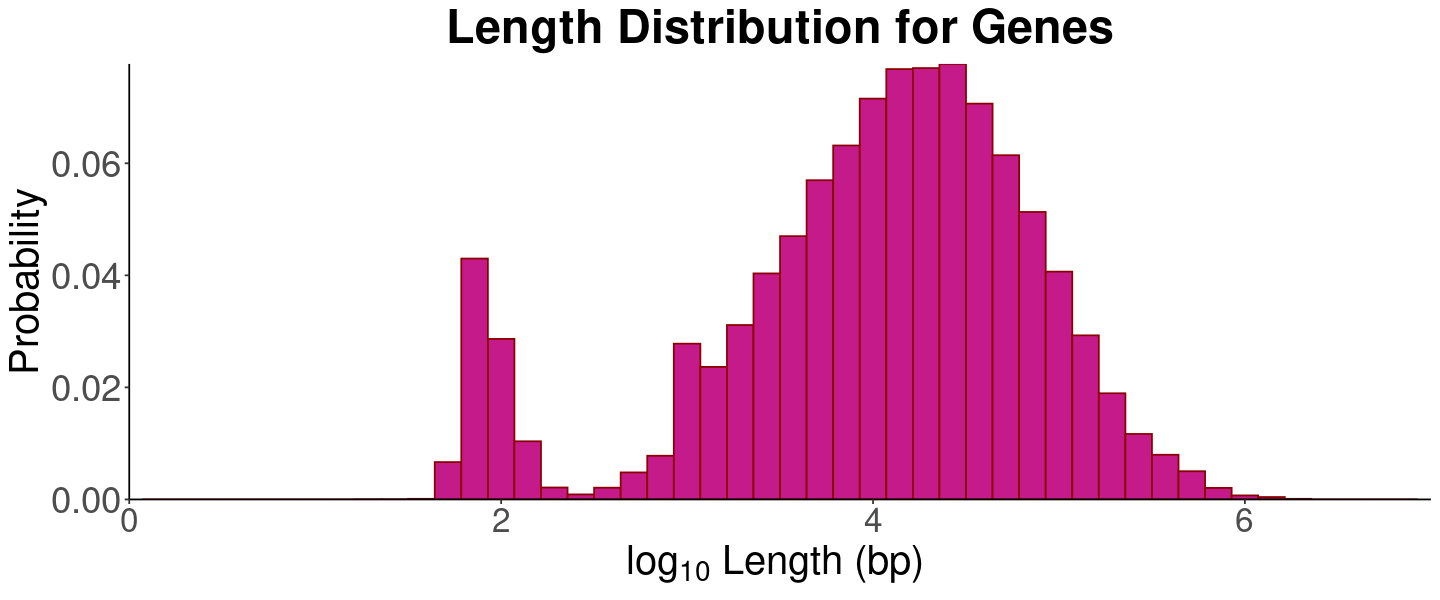

In [13]:
options(repr.plot.width=12, repr.plot.height=5)
gn_len2 <- ggplot(counts_genes, aes(x = log(Length, base=10))) + 
  geom_histogram(aes(y = stat(count) / sum(count)), 
                 bins = 50,fill="#c51b8a",color='darkred') +
theme_classic() +
ggtitle('Length Distribution for Genes') +
xlab(expression(paste(log[10]," Length (bp)", sep=' ')) )+
ylab("Probability") +
scale_x_continuous(expand = c(0, 0), limits = c(0,7)) +
  scale_y_continuous(expand = c(0, 0)) +
theme(plot.title = element_text(hjust = 0.5, 
                                face = "bold",
                               size = 28),
      axis.title = element_text(size = 24), 
      axis.text = element_text(size = 22),
      axis.text.x = element_text(size = 20),
     legend.title = element_text(size = 17),
     legend.text = element_text(size = 15))

gn_len2

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


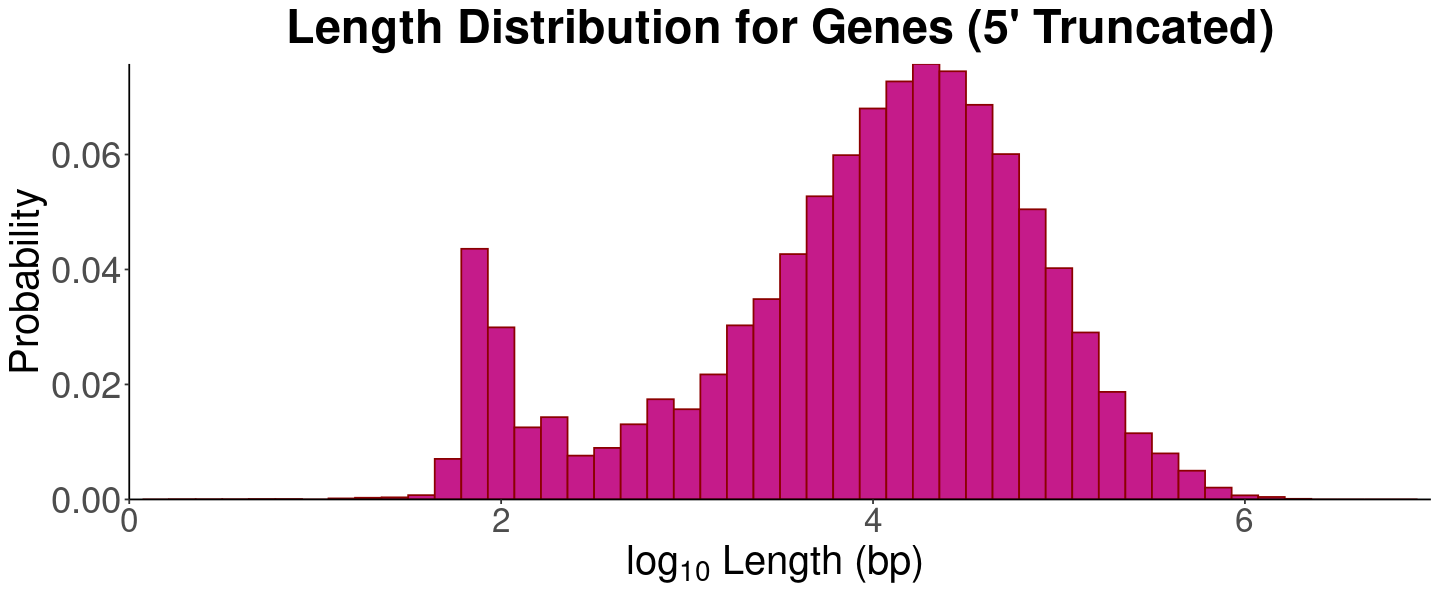

In [14]:
options(repr.plot.width=12, repr.plot.height=5)
gn_len3 <- ggplot(counts_genes_trunc, aes(x = log(Length, base=10))) + 
  geom_histogram(aes(y = stat(count) / sum(count)), 
                 bins = 50,fill="#c51b8a",color='darkred') +
theme_classic() +
ggtitle("Length Distribution for Genes (5' Truncated)") +
xlab(expression(paste(log[10]," Length (bp)", sep=' ')) )+
ylab("Probability") +
scale_x_continuous(expand = c(0, 0), limits = c(0,7)) +
  scale_y_continuous(expand = c(0, 0)) +
theme(plot.title = element_text(hjust = 0.5, 
                                face = "bold",
                               size = 28),
      axis.title = element_text(size = 24), 
      axis.text = element_text(size = 22),
      axis.text.x = element_text(size = 20),
     legend.title = element_text(size = 17),
     legend.text = element_text(size = 15))

gn_len3

### Bidirectionals


Warning message:
“Removed 2 rows containing missing values (geom_bar).”


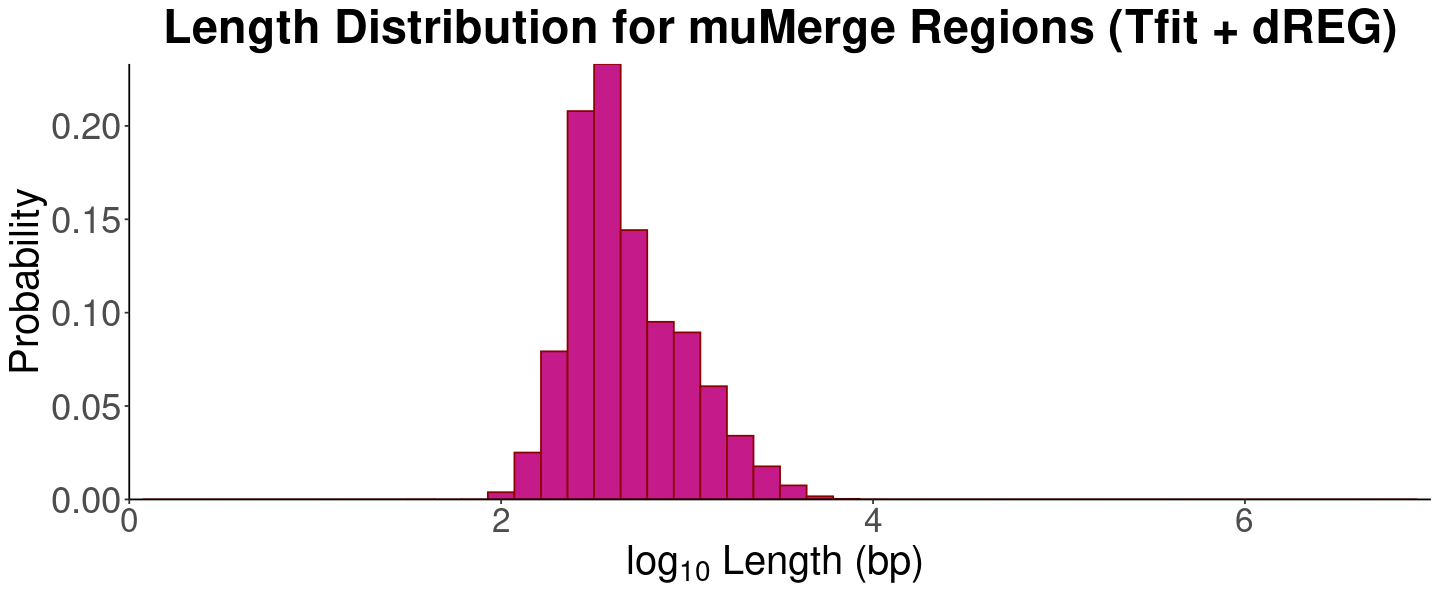

In [15]:
options(repr.plot.width=12, repr.plot.height=5)
bd_len2 <- ggplot(counts_bidirs, aes(x = log(Length, base=10))) + 
  geom_histogram(aes(y = stat(count) / sum(count)), 
                 bins = 50,fill="#c51b8a",color='darkred') +
theme_classic() +
ggtitle('Length Distribution for muMerge Regions (Tfit + dREG)') +
xlab(expression(paste(log[10]," Length (bp)", sep=' ')) )+
ylab("Probability") +
scale_x_continuous(expand = c(0, 0), limits = c(0,7)) +
  scale_y_continuous(expand = c(0, 0)) +
theme(plot.title = element_text(hjust = 0.5, 
                                face = "bold",
                               size = 28),
      axis.title = element_text(size = 24), 
      axis.text = element_text(size = 22),
      axis.text.x = element_text(size = 20),
     legend.title = element_text(size = 17),
     legend.text = element_text(size = 15))

bd_len2

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


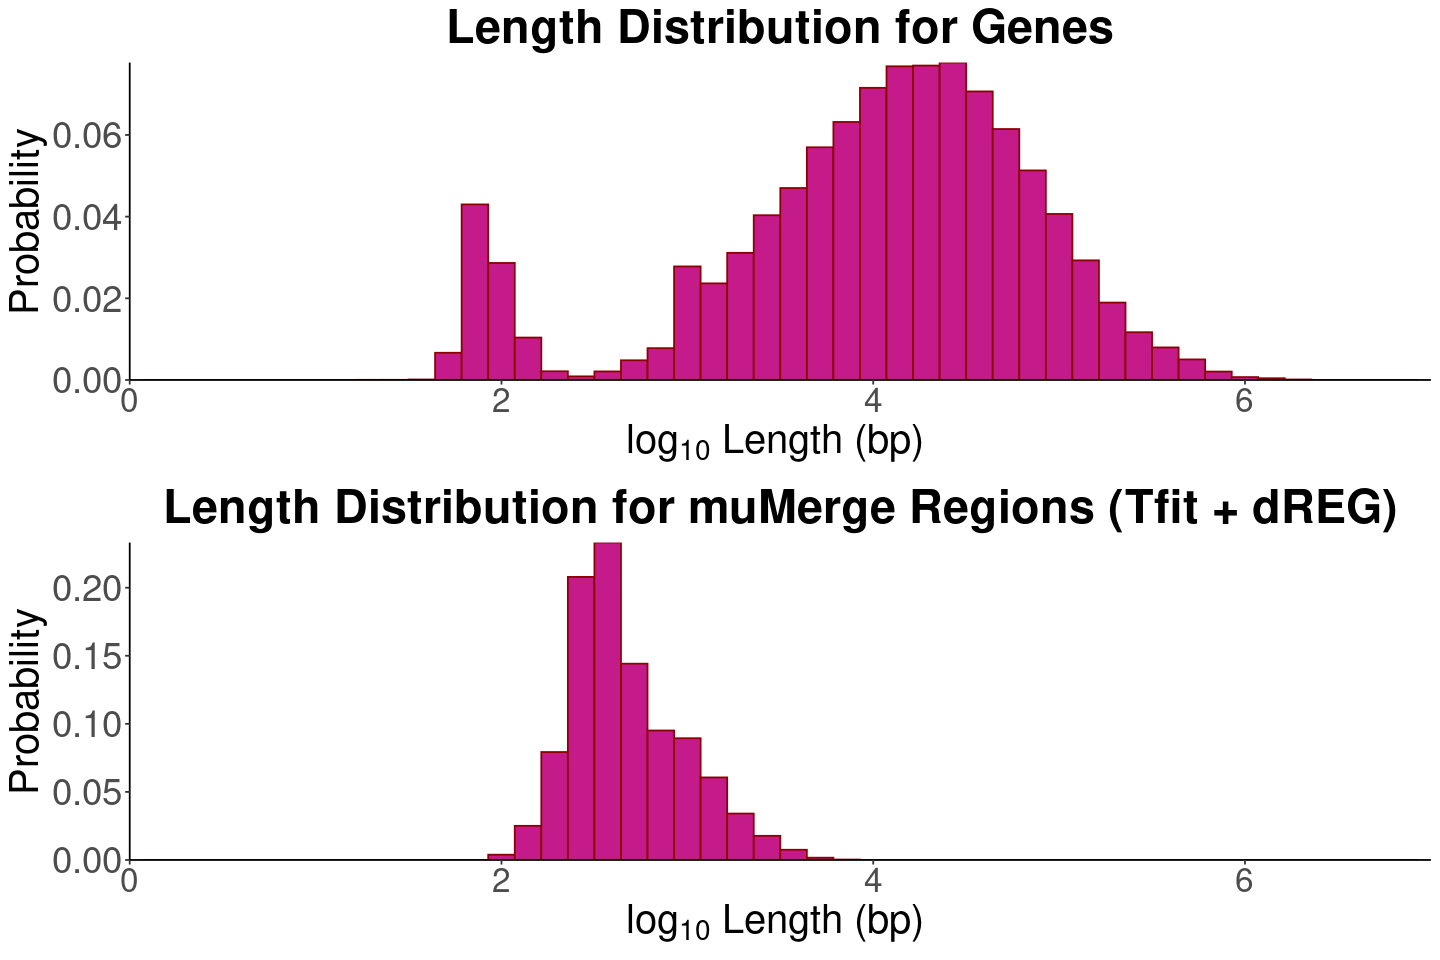

In [16]:
options(repr.plot.width=12, repr.plot.height=8)
cowplot::plot_grid(gn_len2,bd_len2,
          label_size = 24,
         ncol = 1, nrow =2 )

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


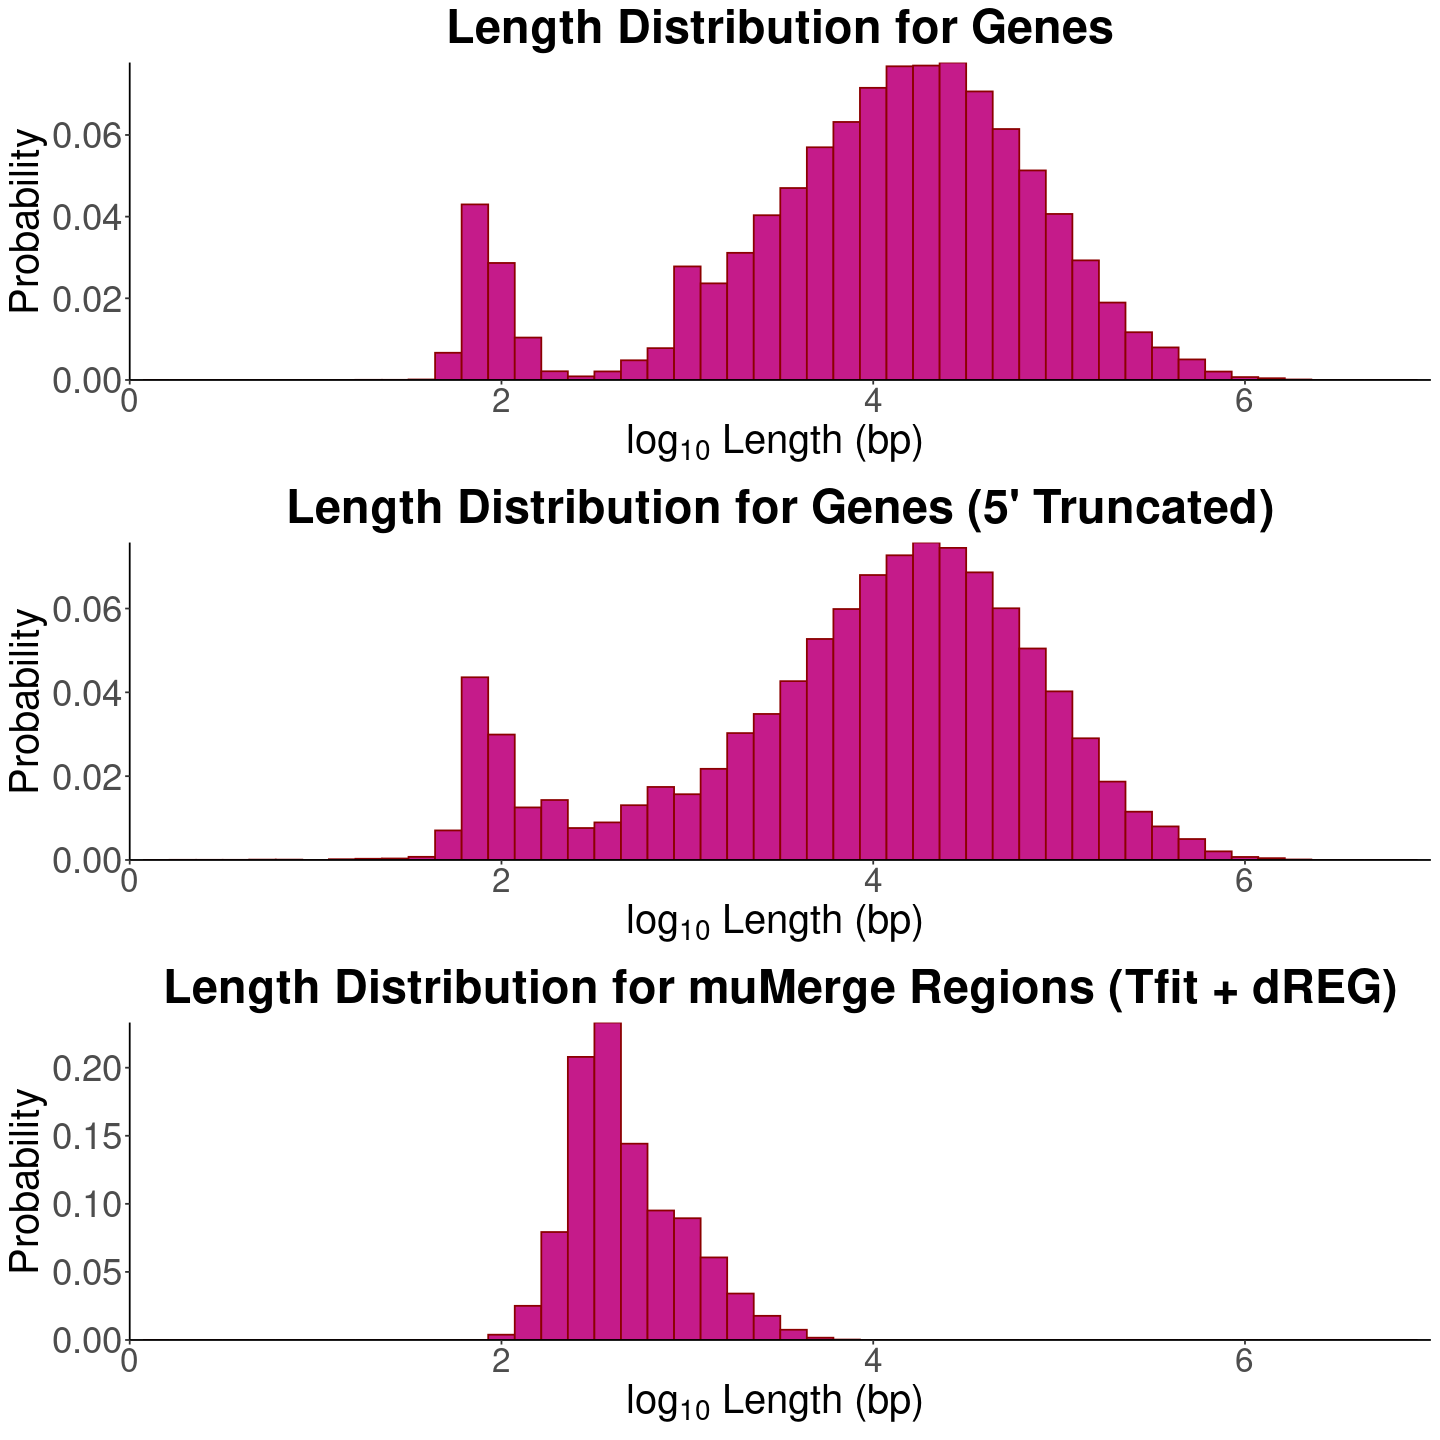

In [17]:
options(repr.plot.width=12, repr.plot.height=12)
cowplot::plot_grid(gn_len2,gn_len3,bd_len2,
          label_size = 24,
         ncol = 1, nrow =3 )

## Sample counts

### Genes

The gene count ranges are similar to the smaller dataset.

See: https://fiji-viz.colorado.edu/jupyterhub/user/rusi2317/notebooks/projects/example_genes_cotranscription_132samples/cotranscription_updated_nascentdb/analysis/01_counts_bidirectionals_genes.ipynb

Average counts by columns

In [18]:
range(colMeans(counts_genes[,9:ncol(counts_genes)]))
median(colMeans(counts_genes[,9:ncol(counts_genes)]))

[1]   16.28866 3237.71870

[1] 404.5021

In [19]:
range(colMeans(counts_genes_trunc[,9:ncol(counts_genes_trunc)]))
median(colMeans(counts_genes_trunc[,9:ncol(counts_genes_trunc)]))

[1]   14.69813 2876.57460

[1] 338.4283

Count variance by column

In [20]:
range(matrixStats::colVars(as.matrix(counts_genes[,9:ncol(counts_genes)])))
median(matrixStats::colVars(as.matrix(counts_genes[,9:ncol(counts_genes)])))

[1] 2.764029e+03 2.801792e+08

[1] 2245127

In [21]:
range(matrixStats::colVars(as.matrix(counts_genes_trunc[,9:ncol(counts_genes_trunc)])))
median(matrixStats::colVars(as.matrix(counts_genes_trunc[,9:ncol(counts_genes_trunc)])))

[1] 2.155684e+03 1.892382e+08

[1] 1613228

### Bidirectionals

In [22]:
range(colMeans(counts_bidirs[,8:ncol(counts_bidirs)]))
median(colMeans(counts_bidirs[,8:ncol(counts_bidirs)]))

[1]  0.3270554 94.8557631

[1] 10.77342

In [23]:
range(matrixStats::colVars(as.matrix(counts_bidirs[,8:ncol(counts_bidirs)])))
median(matrixStats::colVars(as.matrix(counts_bidirs[,8:ncol(counts_bidirs)])))

[1] 1.681308e+01 2.204957e+07

[1] 12622.02

# Gene and bidirectional transcripts

## Merge gene and birectional transcripts

Combine gene counts to bidirectional counts:

1. Gene counts
2. Bidirectional counts for bidirectionals NOT overlapping promoters and genes

In [24]:
head(counts_bidirs$Geneid)

[1] "chr1-3730-7399-dreg"        "chr1-10152-11370-tfit,dreg"
[3] "chr1-12345-12711-dreg"      "chr1-13250-13756-dreg"     
[5] "chr1-15111-15407-dreg"      "chr1-16192-17624-tfit,dreg"

In [25]:
head(bidirs_no_ProGene$Geneid)

[1] "chr1-3730-7399-dreg"        "chr1-30880-31054-tfit"     
[3] "chr1-32579-33067-dreg"      "chr1-38767-38965-tfit,dreg"
[5] "chr1-41386-41764-dreg"      "chr1-46614-47042-dreg"

In [26]:
head(bidirs_no_ProGene500bp$Geneid)

[1] "chr1-3730-7399-dreg"        "chr1-10152-11370-tfit,dreg"
[3] "chr1-30880-31054-tfit"      "chr1-32579-33067-dreg"     
[5] "chr1-38767-38965-tfit,dreg" "chr1-41386-41764-dreg"

In [27]:
#counts_bidirs[counts_bidirs$Geneid %in% bidirs_no_ProGene500bp$Geneid,]
length(counts_bidirs$Geneid)

[1] 652281

In [28]:
bidirs_no_ProGene500bp[!bidirs_no_ProGene500bp$Geneid %in% bidirs_no_ProGene$Geneid,]

V1,V2,V3,V4,Geneid
<chr>,<int>,<int>,<chr>,<chr>
chr1,10151,11371,"tfit,dreg","chr1-10152-11370-tfit,dreg"
chr1,141243,141851,dreg,chr1-141244-141850-dreg
chr1,180714,181647,tfit,chr1-180715-181646-tfit
chr1,188610,189441,dreg,chr1-188611-189440-dreg
chr1,207302,207480,"tfit,dreg","chr1-207303-207479-tfit,dreg"
chr1,629854,629986,"tfit,dreg","chr1-629855-629985-tfit,dreg"
chr1,779665,781540,dreg,chr1-779666-781539-dreg
chr1,920273,921321,dreg,chr1-920274-921320-dreg
chr1,982620,983050,dreg,chr1-982621-983049-dreg


In [29]:
##get bidirectionals not overlapping genes and gene promoters 1kb
counts_bidirs_noProGene <- counts_bidirs[counts_bidirs$Geneid
                                         %in% bidirs_no_ProGene$Geneid,]
dim(counts_bidirs_noProGene)

##get bidirectionals not overlapping genes and gene promoters 500bp
counts_bidirs_noProGene500bp <- counts_bidirs[counts_bidirs$Geneid
                                         %in% bidirs_no_ProGene500bp$Geneid,]
dim(counts_bidirs_noProGene500bp)
head(counts_bidirs_noProGene500bp,3)

[1] 255775    887

[1] 258061    887

chromosome,start,end,Length,Geneid,GeneID,Source,SRZ1950491,SRZ1950493,SRZ1950495,⋯,SRR9833433,SRZ9833428,SRZ9833431,SRZ9833434,SRR11793825,SRR11793826,SRR11793827,SRR11793828,SRR11793829,SRR11793830
<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,3730,7399,3669,chr1-3730-7399-dreg,chr1:3730-7399,dreg,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,10152,11370,1218,"chr1-10152-11370-tfit,dreg",chr1:10152-11370,"tfit,dreg",3,1,2,⋯,1,2,6,16,0,0,0,0,0,0
chr1,30880,31054,174,chr1-30880-31054-tfit,chr1:30880-31054,tfit,0,0,0,⋯,0,0,0,0,2,0,0,0,0,0


In [30]:
head(counts_bidirs_noProGene[,c(1:3,5,4,8:887)])

chromosome,start,end,Geneid,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR9833433,SRZ9833428,SRZ9833431,SRZ9833434,SRR11793825,SRR11793826,SRR11793827,SRR11793828,SRR11793829,SRR11793830
<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,3730,7399,chr1-3730-7399-dreg,3669,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,30880,31054,chr1-30880-31054-tfit,174,0,0,0,0,0,⋯,0,0,0,0,2,0,0,0,0,0
chr1,32579,33067,chr1-32579-33067-dreg,488,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,38767,38965,"chr1-38767-38965-tfit,dreg",198,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,41386,41764,chr1-41386-41764-dreg,378,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,46614,47042,chr1-46614-47042-dreg,428,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0


In [31]:
head(counts_genes[,c(2:4,1,8,9:888)])

chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR9833433,SRZ9833428,SRZ9833431,SRZ9833434,SRR11793825,SRR11793826,SRR11793827,SRR11793828,SRR11793829,SRR11793830
<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,77562416,77682658,ZZZ3,120243,3327,4046,3113,3232,3944,⋯,1719,15138,3474,3910,613,862,3035,2741,636,2503
chr17,4004445,4143030,ZZEF1,138586,1963,2068,2066,1991,2687,⋯,1380,6963,2774,3190,545,715,2303,1906,649,1834
chr7,143381345,143391111,ZYX,9767,71,42,19,20,45,⋯,857,3315,1185,2507,143,177,363,345,123,287
chr1,52726453,52827336,ZYG11B,100884,1111,1087,723,828,1179,⋯,2300,3676,4196,1716,375,500,1563,1332,449,1318
chr1,52842760,52894995,ZYG11A,52236,6,0,2,2,3,⋯,632,892,1056,591,303,434,1354,1164,457,1239
chr3,126458901,126475919,ZXDC,17019,391,375,349,320,495,⋯,1961,1947,3550,2675,101,102,291,265,95,302


### Full length genes & bidirectetionals

In [32]:
counts_bidir_genes <- as.data.frame(rbind(counts_genes[,c(2:4,1,8,9:888)], 
                                          counts_bidirs_noProGene[,c(1:3,5,4,8:887)],
                                         use.names=FALSE))
head(counts_bidir_genes)
dim(counts_bidir_genes)

,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR9833433,SRZ9833428,SRZ9833431,SRZ9833434,SRR11793825,SRR11793826,SRR11793827,SRR11793828,SRR11793829,SRR11793830
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,chr1,77562416,77682658,ZZZ3,120243,3327,4046,3113,3232,3944,⋯,1719,15138,3474,3910,613,862,3035,2741,636,2503
2,chr17,4004445,4143030,ZZEF1,138586,1963,2068,2066,1991,2687,⋯,1380,6963,2774,3190,545,715,2303,1906,649,1834
3,chr7,143381345,143391111,ZYX,9767,71,42,19,20,45,⋯,857,3315,1185,2507,143,177,363,345,123,287
4,chr1,52726453,52827336,ZYG11B,100884,1111,1087,723,828,1179,⋯,2300,3676,4196,1716,375,500,1563,1332,449,1318
5,chr1,52842760,52894995,ZYG11A,52236,6,0,2,2,3,⋯,632,892,1056,591,303,434,1354,1164,457,1239
6,chr3,126458901,126475919,ZXDC,17019,391,375,349,320,495,⋯,1961,1947,3550,2675,101,102,291,265,95,302


[1] 284012    885

In [33]:
counts_bidir_genes500bp <- as.data.frame(rbind(counts_genes[,c(2:4,1,8,9:888)], 
                                          counts_bidirs_noProGene500bp[,c(1:3,5,4,8:887)],
                                         use.names=FALSE))
head(counts_bidir_genes500bp)
dim(counts_bidir_genes500bp)

,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR9833433,SRZ9833428,SRZ9833431,SRZ9833434,SRR11793825,SRR11793826,SRR11793827,SRR11793828,SRR11793829,SRR11793830
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,chr1,77562416,77682658,ZZZ3,120243,3327,4046,3113,3232,3944,⋯,1719,15138,3474,3910,613,862,3035,2741,636,2503
2,chr17,4004445,4143030,ZZEF1,138586,1963,2068,2066,1991,2687,⋯,1380,6963,2774,3190,545,715,2303,1906,649,1834
3,chr7,143381345,143391111,ZYX,9767,71,42,19,20,45,⋯,857,3315,1185,2507,143,177,363,345,123,287
4,chr1,52726453,52827336,ZYG11B,100884,1111,1087,723,828,1179,⋯,2300,3676,4196,1716,375,500,1563,1332,449,1318
5,chr1,52842760,52894995,ZYG11A,52236,6,0,2,2,3,⋯,632,892,1056,591,303,434,1354,1164,457,1239
6,chr3,126458901,126475919,ZXDC,17019,391,375,349,320,495,⋯,1961,1947,3550,2675,101,102,291,265,95,302


[1] 286298    885

### 5' truncated genes & bidirectionals 

In [34]:
counts_bidir_genes_trunc <- as.data.frame(rbind(counts_genes_trunc[,c(2:4,1,8,9:888)], 
                                          counts_bidirs_noProGene[,c(1:3,5,4,8:887)],
                                         use.names=FALSE))
head(counts_bidir_genes_trunc)
dim(counts_bidir_genes_trunc)

,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR9833433,SRZ9833428,SRZ9833431,SRZ9833434,SRR11793825,SRR11793826,SRR11793827,SRR11793828,SRR11793829,SRR11793830
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,chr1,77562416,77681908,ZZZ3,119493,3207,3976,3058,3191,3896,⋯,1447,14963,2733,3146,588,838,2977,2700,608,2435
2,chr17,4004445,4142280,ZZEF1,137836,1882,2026,2031,1939,2630,⋯,1015,6772,1756,2415,534,709,2286,1900,636,1826
3,chr7,143382095,143391111,ZYX,9017,55,33,14,19,39,⋯,329,3052,714,1434,123,156,312,306,118,273
4,chr1,52727203,52827336,ZYG11B,100134,1043,1040,702,794,1152,⋯,2087,3632,3584,1112,344,462,1505,1301,421,1296
5,chr1,52843510,52894995,ZYG11A,51486,6,0,2,2,3,⋯,183,802,193,209,275,380,1255,1091,400,1134
6,chr3,126458901,126475169,ZXDC,16269,332,334,323,281,445,⋯,292,1696,589,845,83,86,259,231,69,264


[1] 284012    885

In [35]:
counts_bidir_genes_trunc500bp <- as.data.frame(rbind(counts_genes_trunc[,c(2:4,1,8,9:888)], 
                                          counts_bidirs_noProGene500bp[,c(1:3,5,4,8:887)],
                                         use.names=FALSE))
head(counts_bidir_genes_trunc500bp)
dim(counts_bidir_genes_trunc500bp)

,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR9833433,SRZ9833428,SRZ9833431,SRZ9833434,SRR11793825,SRR11793826,SRR11793827,SRR11793828,SRR11793829,SRR11793830
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,chr1,77562416,77681908,ZZZ3,119493,3207,3976,3058,3191,3896,⋯,1447,14963,2733,3146,588,838,2977,2700,608,2435
2,chr17,4004445,4142280,ZZEF1,137836,1882,2026,2031,1939,2630,⋯,1015,6772,1756,2415,534,709,2286,1900,636,1826
3,chr7,143382095,143391111,ZYX,9017,55,33,14,19,39,⋯,329,3052,714,1434,123,156,312,306,118,273
4,chr1,52727203,52827336,ZYG11B,100134,1043,1040,702,794,1152,⋯,2087,3632,3584,1112,344,462,1505,1301,421,1296
5,chr1,52843510,52894995,ZYG11A,51486,6,0,2,2,3,⋯,183,802,193,209,275,380,1255,1091,400,1134
6,chr3,126458901,126475169,ZXDC,16269,332,334,323,281,445,⋯,292,1696,589,845,83,86,259,231,69,264


[1] 286298    885

## Calculate TPMs for all genes and bidirs

### Genes

In [36]:
gene_bidir_tpms <- tpm_calculation(counts_bidir_genes[c(6:ncol(counts_bidir_genes))], 
                        counts_bidir_genes$Length)

gene_bidir_tpm_df <- cbind(counts_bidir_genes[c(1:5)],
                as.data.frame(gene_bidir_tpms))

dim(gene_bidir_tpm_df)
head(gene_bidir_tpm_df)

[1] 284012    885

,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR9833433,SRZ9833428,SRZ9833431,SRZ9833434,SRR11793825,SRR11793826,SRR11793827,SRR11793828,SRR11793829,SRR11793830
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,77562416,77682658,ZZZ3,120243,6.04104608,8.500381,6.128151747,6.32736293,6.43042127,⋯,1.872764,10.191984,1.575846,1.9782447,5.943808,6.166874,5.773782,6.015668,0.5651401,4.867103
2,chr17,4004445,4143030,ZZEF1,138586,3.09257393,3.769672,3.528752108,3.38191819,3.80111167,⋯,1.304448,4.067495,1.091769,1.4003429,4.585020,4.438174,3.801334,3.629428,0.5003618,3.094207
3,chr7,143381345,143391111,ZYX,9767,1.58714393,1.086327,0.460471342,0.48203659,0.90326181,⋯,11.494406,27.477194,6.617607,15.6155111,17.070213,15.589411,8.501723,9.321644,1.3455589,6.870529
4,chr1,52726453,52827336,ZYG11B,100884,2.40442324,2.721947,1.696391928,1.93205391,2.29115164,⋯,2.986568,2.949872,2.268595,1.0348039,4.333842,4.263491,3.544036,3.484308,0.4755354,3.054658
5,chr1,52842760,52894995,ZYG11A,52236,0.02507844,0.000000,0.009062964,0.00901304,0.01125936,⋯,1.584944,1.382436,1.102650,0.6883045,6.762960,7.147225,5.929393,5.880546,0.9347707,5.545885
6,chr3,126458901,126475919,ZXDC,17019,5.01605015,5.566338,4.854020230,4.42616029,5.70208232,⋯,15.094212,9.261513,11.377272,9.5620895,6.919129,5.155654,3.911294,4.109098,0.5964147,4.148990


#### Summary statistics

In [37]:
ncol(counts_bidir_genes)

[1] 885

In [38]:
##get summary statistics
gene_bidir_tpm_df$stdev <- apply(gene_bidir_tpm_df[c(6:ncol(counts_bidir_genes))], 1, sd)
gene_bidir_tpm_df$variance <- apply(gene_bidir_tpm_df[c(6:ncol(counts_bidir_genes))], 1, var)
gene_bidir_tpm_df$mean <- apply(gene_bidir_tpm_df[c(6:ncol(counts_bidir_genes))], 1, mean)
gene_bidir_tpm_df$median <- apply(gene_bidir_tpm_df[c(6:ncol(counts_bidir_genes))], 1, median)
gene_bidir_tpm_df$coefvar <- gene_bidir_tpm_df$stdev/gene_bidir_tpm_df$mean #apply(gene_bidir_tpm_df[c(6:ncol(counts_bidir_genes))], 1, cv)
gene_bidir_tpm_df$max <- apply(gene_bidir_tpm_df[c(6:ncol(counts_bidir_genes))], 1, max)
head(gene_bidir_tpm_df)

,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR11793827,SRR11793828,SRR11793829,SRR11793830,stdev,variance,mean,median,coefvar,max
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,77562416,77682658,ZZZ3,120243,6.04104608,8.500381,6.128151747,6.32736293,6.43042127,⋯,5.773782,6.015668,0.5651401,4.867103,4.140656,17.145028,6.490899,5.920378,0.6379171,37.49324
2,chr17,4004445,4143030,ZZEF1,138586,3.09257393,3.769672,3.528752108,3.38191819,3.80111167,⋯,3.801334,3.629428,0.5003618,3.094207,2.777647,7.715321,4.248136,3.673690,0.6538507,19.25574
3,chr7,143381345,143391111,ZYX,9767,1.58714393,1.086327,0.460471342,0.48203659,0.90326181,⋯,8.501723,9.321644,1.3455589,6.870529,19.334068,373.806188,16.423841,10.985491,1.1771953,188.58948
4,chr1,52726453,52827336,ZYG11B,100884,2.40442324,2.721947,1.696391928,1.93205391,2.29115164,⋯,3.544036,3.484308,0.4755354,3.054658,2.250495,5.064730,2.776557,2.320942,0.8105345,22.18181
5,chr1,52842760,52894995,ZYG11A,52236,0.02507844,0.000000,0.009062964,0.00901304,0.01125936,⋯,5.929393,5.880546,0.9347707,5.545885,3.761215,14.146738,2.605882,1.136030,1.4433557,28.51244
6,chr3,126458901,126475919,ZXDC,17019,5.01605015,5.566338,4.854020230,4.42616029,5.70208232,⋯,3.911294,4.109098,0.5964147,4.148990,5.833403,34.028588,9.555510,8.504887,0.6104753,47.13325


In [38]:
#gene_bidir_tpm_df$coefvar <- apply(gene_bidir_tpm_df[c(6:ncol(counts_bidir_genes))], 1, cv)

#### Filter trancripts based on counts


In [39]:
##filter rows with all TPM values not 0
rows_without_zero <- apply(gene_bidir_tpm_df[7:ncol(counts_genes)], 1, function(row) any(row > 0 ))
                        
##Subset the rows that fulfill the above criteria
tpm_df_genes_bidir_transcribed <- gene_bidir_tpm_df[rows_without_zero,]
                           

In [40]:
dim(tpm_df_genes_bidir_transcribed)

[1] 282242    891

#### Add bidirectional/gene ID column

In [41]:
tpm_df_genes_bidir_transcribed$bidir <- as.character(lapply(strsplit(as.character(tpm_df_genes_bidir_transcribed$GeneID), '-'), `[`, 4))
head(tpm_df_genes_bidir_transcribed)
tail(tpm_df_genes_bidir_transcribed)

,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR11793828,SRR11793829,SRR11793830,stdev,variance,mean,median,coefvar,max,bidir
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,chr1,77562416,77682658,ZZZ3,120243,6.04104608,8.500381,6.128151747,6.32736293,6.43042127,⋯,6.015668,0.5651401,4.867103,4.140656,17.145028,6.490899,5.920378,0.6379171,37.49324,NA
2,chr17,4004445,4143030,ZZEF1,138586,3.09257393,3.769672,3.528752108,3.38191819,3.80111167,⋯,3.629428,0.5003618,3.094207,2.777647,7.715321,4.248136,3.673690,0.6538507,19.25574,NA
3,chr7,143381345,143391111,ZYX,9767,1.58714393,1.086327,0.460471342,0.48203659,0.90326181,⋯,9.321644,1.3455589,6.870529,19.334068,373.806188,16.423841,10.985491,1.1771953,188.58948,NA
4,chr1,52726453,52827336,ZYG11B,100884,2.40442324,2.721947,1.696391928,1.93205391,2.29115164,⋯,3.484308,0.4755354,3.054658,2.250495,5.064730,2.776557,2.320942,0.8105345,22.18181,NA
5,chr1,52842760,52894995,ZYG11A,52236,0.02507844,0.000000,0.009062964,0.00901304,0.01125936,⋯,5.880546,0.9347707,5.545885,3.761215,14.146738,2.605882,1.136030,1.4433557,28.51244,NA
6,chr3,126458901,126475919,ZXDC,17019,5.01605015,5.566338,4.854020230,4.42616029,5.70208232,⋯,4.109098,0.5964147,4.148990,5.833403,34.028588,9.555510,8.504887,0.6104753,47.13325,NA


,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR11793828,SRR11793829,SRR11793830,stdev,variance,mean,median,coefvar,max,bidir
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
284007,chrY,56877879,56878049,chrY-56877879-56878049-tfit,170,0,0,0,0,0,⋯,0.0000000,0,0.0000000,0.8023843,0.64382063,0.11475204,0,6.992332,13.203867,tfit
284008,chrY,56878648,56878950,"chrY-56878648-56878950-tfit,dreg",302,0,0,0,0,0,⋯,0.8738315,0,0.7742167,2.0344029,4.13879508,0.35441159,0,5.740227,32.251448,"tfit,dreg"
284009,chrY,56881703,56881987,"chrY-56881703-56881987-tfit,dreg",284,0,0,0,0,0,⋯,0.0000000,0,0.0000000,2.0231772,4.09324609,0.20457207,0,9.889802,54.939976,"tfit,dreg"
284010,chrY,56883159,56883487,chrY-56883159-56883487-dreg,328,0,0,0,0,0,⋯,0.0000000,0,0.0000000,0.3458919,0.11964122,0.05826328,0,5.936705,6.670231,dreg
284011,chrY,56883555,56883771,chrY-56883555-56883771-tfit,216,0,0,0,0,0,⋯,0.0000000,0,0.0000000,1.5781528,2.49056625,0.10278229,0,15.354327,45.723784,tfit
284012,chrY,56884671,56885119,chrY-56884671-56885119-dreg,448,0,0,0,0,0,⋯,0.0000000,0,0.0000000,0.1623258,0.02634966,0.02185622,0,7.426983,2.646486,dreg


In [42]:
transcribed_geneid <- tpm_df_genes_bidir_transcribed[is.na(tpm_df_genes_bidir_transcribed$bidir),]
dim(transcribed_geneid)
head(transcribed_geneid, 3)
tail(transcribed_geneid, 3)

[1] 28018   892

,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR11793828,SRR11793829,SRR11793830,stdev,variance,mean,median,coefvar,max,bidir
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,chr1,77562416,77682658,ZZZ3,120243,6.041046,8.500381,6.1281517,6.3273629,6.4304213,⋯,6.015668,0.5651401,4.867103,4.140656,17.145028,6.490899,5.920378,0.6379171,37.49324,NA
2,chr17,4004445,4143030,ZZEF1,138586,3.092574,3.769672,3.5287521,3.3819182,3.8011117,⋯,3.629428,0.5003618,3.094207,2.777647,7.715321,4.248136,3.673690,0.6538507,19.25574,NA
3,chr7,143381345,143391111,ZYX,9767,1.587144,1.086327,0.4604713,0.4820366,0.9032618,⋯,9.321644,1.3455589,6.870529,19.334068,373.806188,16.423841,10.985491,1.1771953,188.58948,NA


,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR11793828,SRR11793829,SRR11793830,stdev,variance,mean,median,coefvar,max,bidir
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
28235,chr10,50799409,50885627,A1CF,86219,0.000000,0.008790035,0.00000,0.00000,0.004547674,⋯,0.01836466,0.01115317,0.00542371,1.081002,1.168565,0.128504,0.002794921,8.412204,15.36740,NA
28236,chr19,58351970,58355183,A1BG-AS1,3214,15.556388,11.004099353,13.03580,8.93563,10.552674749,⋯,9.03194801,0.99731920,6.83835182,13.765780,189.496707,8.733684,5.349873806,1.576171,240.33947,NA
28237,chr19,58345183,58353492,A1BG,8310,4.676685,3.495981745,2.13634,2.26621,3.137710992,⋯,0.95269711,0.30858088,0.73154624,3.195592,10.211808,2.883564,1.903160061,1.108209,31.43148,NA


In [43]:
gn_dreg_tfit_list <- (unique(c(rownames(tpm_df_genes_bidir_transcribed[grep("dreg,", 
                                                                            tpm_df_genes_bidir_transcribed$bidir),]),
                            rownames(tpm_df_genes_bidir_transcribed[grep("tfit,",
                                                                         tpm_df_genes_bidir_transcribed$bidir),]),
                            rownames(tpm_df_genes_bidir_transcribed[grep(",dreg",
                                                                         tpm_df_genes_bidir_transcribed$bidir),]),
                            rownames(tpm_df_genes_bidir_transcribed[grep(",tfit",
                                                                         tpm_df_genes_bidir_transcribed$bidir),]))))

gn_tpm_tfit_dreg_df <- tpm_df_genes_bidir_transcribed[gn_dreg_tfit_list, ]
dim(gn_tpm_tfit_dreg_df)

[1] 105198    892

In [44]:
gn_tpm_dreg_df <- subset(tpm_df_genes_bidir_transcribed, bidir=='dreg')
dim(gn_tpm_dreg_df)

[1] 86749   892

In [45]:
gn_tpm_tfit_df <- subset(tpm_df_genes_bidir_transcribed, bidir=='tfit')
dim(gn_tpm_tfit_df)

[1] 62277   892

In [46]:
transcribed_geneid$bidir_id <- rep('Gene', nrow(transcribed_geneid))
gn_tpm_tfit_dreg_df$bidir_id <- rep('Tfit & dREG', nrow(gn_tpm_tfit_dreg_df))
gn_tpm_tfit_df$bidir_id <- rep('Tfit', nrow(gn_tpm_tfit_df))
gn_tpm_dreg_df$bidir_id <- rep('dREG', nrow(gn_tpm_dreg_df))

gn_bdr_tpm_updated_df <- rbind(transcribed_geneid,
                               gn_tpm_tfit_dreg_df,
                               gn_tpm_tfit_df,
                               gn_tpm_dreg_df)

dim(gn_bdr_tpm_updated_df)
head(gn_bdr_tpm_updated_df)

[1] 282242    893

,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR11793829,SRR11793830,stdev,variance,mean,median,coefvar,max,bidir,bidir_id
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,chr1,77562416,77682658,ZZZ3,120243,6.04104608,8.500381,6.128151747,6.32736293,6.43042127,⋯,0.5651401,4.867103,4.140656,17.145028,6.490899,5.920378,0.6379171,37.49324,NA,Gene
2,chr17,4004445,4143030,ZZEF1,138586,3.09257393,3.769672,3.528752108,3.38191819,3.80111167,⋯,0.5003618,3.094207,2.777647,7.715321,4.248136,3.673690,0.6538507,19.25574,NA,Gene
3,chr7,143381345,143391111,ZYX,9767,1.58714393,1.086327,0.460471342,0.48203659,0.90326181,⋯,1.3455589,6.870529,19.334068,373.806188,16.423841,10.985491,1.1771953,188.58948,NA,Gene
4,chr1,52726453,52827336,ZYG11B,100884,2.40442324,2.721947,1.696391928,1.93205391,2.29115164,⋯,0.4755354,3.054658,2.250495,5.064730,2.776557,2.320942,0.8105345,22.18181,NA,Gene
5,chr1,52842760,52894995,ZYG11A,52236,0.02507844,0.000000,0.009062964,0.00901304,0.01125936,⋯,0.9347707,5.545885,3.761215,14.146738,2.605882,1.136030,1.4433557,28.51244,NA,Gene
6,chr3,126458901,126475919,ZXDC,17019,5.01605015,5.566338,4.854020230,4.42616029,5.70208232,⋯,0.5964147,4.148990,5.833403,34.028588,9.555510,8.504887,0.6104753,47.13325,NA,Gene


In [47]:
gn_bdr_tpm_updated_df$bidir_id <- factor(gn_bdr_tpm_updated_df$bidir_id, 
                                         levels = c('dREG','Tfit','Tfit & dREG','Gene'))

In [48]:
#filter just counts and metadata
gn_bdr_tpm_minimal_df <- gn_bdr_tpm_updated_df[,c('GeneID','chromosome',
                             'start','end','Length','bidir_id', 
                              colnames(gn_bdr_tpm_updated_df[c(6:885)]))]
dim(gn_bdr_tpm_minimal_df)
tail(gn_bdr_tpm_minimal_df)

[1] 282242    886

,GeneID,chromosome,start,end,Length,bidir_id,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,⋯,SRR9833433,SRZ9833428,SRZ9833431,SRZ9833434,SRR11793825,SRR11793826,SRR11793827,SRR11793828,SRR11793829,SRR11793830
,<chr>,<chr>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
283981,chrY-56679417-56679635-dreg,chrY,56679417,56679635,218,dREG,0,0,0,0,⋯,0,0,0,0,0,0,0.0000000,0.000000,0,0.0000000
283988,chrY-56823211-56825224-dreg,chrY,56823211,56825224,2013,dREG,0,0,0,0,⋯,0,0,0,0,0,0,0.3409094,1.179868,0,0.1161517
283991,chrY-56829421-56829779-dreg,chrY,56829421,56829779,358,dREG,0,0,0,0,⋯,0,0,0,0,0,0,0.0000000,0.000000,0,1.9593304
284003,chrY-56864435-56864843-dreg,chrY,56864435,56864843,408,dREG,0,0,0,0,⋯,0,0,0,0,0,0,0.5606623,0.000000,0,0.0000000
284010,chrY-56883159-56883487-dreg,chrY,56883159,56883487,328,dREG,0,0,0,0,⋯,0,0,0,0,0,0,0.0000000,0.000000,0,0.0000000
284012,chrY-56884671-56885119-dreg,chrY,56884671,56885119,448,dREG,0,0,0,0,⋯,0,0,0,0,0,0,0.0000000,0.000000,0,0.0000000


In [49]:
colnames(gn_bdr_tpm_minimal_df)[c(1:6)] <- c('Geneid','Chr','Start','End','Length','Bidirid')
head(gn_bdr_tpm_minimal_df)

,Geneid,Chr,Start,End,Length,Bidirid,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,⋯,SRR9833433,SRZ9833428,SRZ9833431,SRZ9833434,SRR11793825,SRR11793826,SRR11793827,SRR11793828,SRR11793829,SRR11793830
,<chr>,<chr>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ZZZ3,chr1,77562416,77682658,120243,Gene,6.04104608,8.500381,6.128151747,6.32736293,⋯,1.872764,10.191984,1.575846,1.9782447,5.943808,6.166874,5.773782,6.015668,0.5651401,4.867103
2,ZZEF1,chr17,4004445,4143030,138586,Gene,3.09257393,3.769672,3.528752108,3.38191819,⋯,1.304448,4.067495,1.091769,1.4003429,4.585020,4.438174,3.801334,3.629428,0.5003618,3.094207
3,ZYX,chr7,143381345,143391111,9767,Gene,1.58714393,1.086327,0.460471342,0.48203659,⋯,11.494406,27.477194,6.617607,15.6155111,17.070213,15.589411,8.501723,9.321644,1.3455589,6.870529
4,ZYG11B,chr1,52726453,52827336,100884,Gene,2.40442324,2.721947,1.696391928,1.93205391,⋯,2.986568,2.949872,2.268595,1.0348039,4.333842,4.263491,3.544036,3.484308,0.4755354,3.054658
5,ZYG11A,chr1,52842760,52894995,52236,Gene,0.02507844,0.000000,0.009062964,0.00901304,⋯,1.584944,1.382436,1.102650,0.6883045,6.762960,7.147225,5.929393,5.880546,0.9347707,5.545885
6,ZXDC,chr3,126458901,126475919,17019,Gene,5.01605015,5.566338,4.854020230,4.42616029,⋯,15.094212,9.261513,11.377272,9.5620895,6.919129,5.155654,3.911294,4.109098,0.5964147,4.148990


### Genes : 5' truncated

In [50]:
gene_bidir_tpms_trunc <- tpm_calculation(counts_bidir_genes_trunc[c(6:ncol(counts_bidir_genes_trunc))], 
                        counts_bidir_genes_trunc$Length)

gene_bidir_tpm_trunc_df <- cbind(counts_bidir_genes_trunc[c(1:5)],
                as.data.frame(gene_bidir_tpms_trunc))

dim(gene_bidir_tpm_trunc_df)
head(gene_bidir_tpm_trunc_df)

[1] 284012    885

,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR9833433,SRZ9833428,SRZ9833431,SRZ9833434,SRR11793825,SRR11793826,SRR11793827,SRR11793828,SRR11793829,SRR11793830
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,77562416,77681908,ZZZ3,119493,5.89606855,8.4220380,6.065659968,6.340954238,6.4128030,⋯,1.6808694,9.905381,1.3004700,1.6615380,5.678745,5.980955,5.494260,5.735158,0.5292324,4.595830
2,chr17,4004445,4142280,ZZEF1,137836,2.99959752,3.7204037,3.492450878,3.340299643,3.7528785,⋯,1.0221421,3.886416,0.7243776,1.1057285,4.470912,4.386848,3.657518,3.498767,0.4799321,2.987759
3,chr7,143382095,143391111,ZYX,9017,1.34000571,0.9263288,0.368001010,0.500336067,0.8506951,⋯,5.0645602,26.774256,4.5023507,10.0364730,15.742024,14.754739,7.630717,8.613576,1.3611477,6.828229
4,chr1,52727203,52827336,ZYG11B,100134,2.28827793,2.6288455,1.661646325,1.882821794,2.2627800,⋯,2.8930024,2.869189,2.0351181,0.7008374,3.964555,3.934861,3.314574,3.297766,0.4373064,2.918979
5,chr1,52843510,52894995,ZYG11A,51486,0.02560166,0.0000000,0.009207122,0.009223826,0.0114605,⋯,0.4933667,1.232197,0.2131431,0.2561835,6.163978,6.294532,5.375606,5.378482,0.8080834,4.967426
6,chr3,126458901,126475169,ZXDC,16269,4.48314983,5.1963559,4.705705105,4.101245248,5.3798550,⋯,2.4913222,8.246315,2.0585319,3.2778561,5.887552,4.508235,3.510846,3.603921,0.4411371,3.659743


#### Summary statistics

In [51]:
##get summary statistics
gene_bidir_tpm_trunc_df$stdev <- apply(gene_bidir_tpm_trunc_df[c(6:ncol(counts_bidir_genes))], 1, sd)
gene_bidir_tpm_trunc_df$variance <- apply(gene_bidir_tpm_trunc_df[c(6:ncol(counts_bidir_genes))], 1, var)
gene_bidir_tpm_trunc_df$mean <- apply(gene_bidir_tpm_trunc_df[c(6:ncol(counts_bidir_genes))], 1, mean)
gene_bidir_tpm_trunc_df$median <- apply(gene_bidir_tpm_trunc_df[c(6:ncol(counts_bidir_genes))], 1, median)
gene_bidir_tpm_trunc_df$coefvar <- gene_bidir_tpm_trunc_df$stdev/gene_bidir_tpm_trunc_df$mean #apply(gene_bidir_tpm_trunc_df[c(6:ncol(counts_bidir_genes))], 1, cv)
gene_bidir_tpm_trunc_df$max <- apply(gene_bidir_tpm_trunc_df[c(6:ncol(counts_bidir_genes))], 1, max)
head(gene_bidir_tpm_trunc_df)

,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR11793827,SRR11793828,SRR11793829,SRR11793830,stdev,variance,mean,median,coefvar,max
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,77562416,77681908,ZZZ3,119493,5.89606855,8.4220380,6.065659968,6.340954238,6.4128030,⋯,5.494260,5.735158,0.5292324,4.595830,4.099927,16.809403,6.350162,5.746589,0.6456414,37.16213
2,chr17,4004445,4142280,ZZEF1,137836,2.99959752,3.7204037,3.492450878,3.340299643,3.7528785,⋯,3.657518,3.498767,0.4799321,2.987759,2.784332,7.752505,4.213346,3.657366,0.6608363,18.71432
3,chr7,143382095,143391111,ZYX,9017,1.34000571,0.9263288,0.368001010,0.500336067,0.8506951,⋯,7.630717,8.613576,1.3611477,6.828229,19.362806,374.918246,15.029889,8.398350,1.2882867,190.32745
4,chr1,52727203,52827336,ZYG11B,100134,2.28827793,2.6288455,1.661646325,1.882821794,2.2627800,⋯,3.314574,3.297766,0.4373064,2.918979,2.150771,4.625818,2.584695,2.125551,0.8321180,22.05660
5,chr1,52843510,52894995,ZYG11A,51486,0.02560166,0.0000000,0.009207122,0.009223826,0.0114605,⋯,5.375606,5.378482,0.8080834,4.967426,3.376006,11.397417,2.223047,1.007828,1.5186389,29.01328
6,chr3,126458901,126475169,ZXDC,16269,4.48314983,5.1963559,4.705705105,4.101245248,5.3798550,⋯,3.510846,3.603921,0.4411371,3.659743,5.610681,31.479741,8.468098,7.282790,0.6625669,54.13730


#### Filter transcripts based on counts 

In [52]:
##filter rows with all TPM values not 0
rows_without_zero_trunc <- apply(gene_bidir_tpm_trunc_df[7:ncol(counts_genes_trunc)], 1, function(row) any(row > 0 ))
                        
##Subset the rows that fulfill the above criteria
tpm_df_genes_bidir_transcribed_trunc <- gene_bidir_tpm_trunc_df[rows_without_zero_trunc,]
                           

In [53]:
dim(tpm_df_genes_bidir_transcribed_trunc)

[1] 282165    891

#### Add bidirectional/gene ID column 

In [54]:
tpm_df_genes_bidir_transcribed_trunc$bidir <- as.character(lapply(strsplit(as.character(tpm_df_genes_bidir_transcribed_trunc$GeneID), '-'), `[`, 4))
head(tpm_df_genes_bidir_transcribed_trunc)
tail(tpm_df_genes_bidir_transcribed_trunc)

,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR11793828,SRR11793829,SRR11793830,stdev,variance,mean,median,coefvar,max,bidir
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,chr1,77562416,77681908,ZZZ3,119493,5.89606855,8.4220380,6.065659968,6.340954238,6.4128030,⋯,5.735158,0.5292324,4.595830,4.099927,16.809403,6.350162,5.746589,0.6456414,37.16213,NA
2,chr17,4004445,4142280,ZZEF1,137836,2.99959752,3.7204037,3.492450878,3.340299643,3.7528785,⋯,3.498767,0.4799321,2.987759,2.784332,7.752505,4.213346,3.657366,0.6608363,18.71432,NA
3,chr7,143382095,143391111,ZYX,9017,1.34000571,0.9263288,0.368001010,0.500336067,0.8506951,⋯,8.613576,1.3611477,6.828229,19.362806,374.918246,15.029889,8.398350,1.2882867,190.32745,NA
4,chr1,52727203,52827336,ZYG11B,100134,2.28827793,2.6288455,1.661646325,1.882821794,2.2627800,⋯,3.297766,0.4373064,2.918979,2.150771,4.625818,2.584695,2.125551,0.8321180,22.05660,NA
5,chr1,52843510,52894995,ZYG11A,51486,0.02560166,0.0000000,0.009207122,0.009223826,0.0114605,⋯,5.378482,0.8080834,4.967426,3.376006,11.397417,2.223047,1.007828,1.5186389,29.01328,NA
6,chr3,126458901,126475169,ZXDC,16269,4.48314983,5.1963559,4.705705105,4.101245248,5.3798550,⋯,3.603921,0.4411371,3.659743,5.610681,31.479741,8.468098,7.282790,0.6625669,54.13730,NA


,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR11793828,SRR11793829,SRR11793830,stdev,variance,mean,median,coefvar,max,bidir
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
284007,chrY,56877879,56878049,chrY-56877879-56878049-tfit,170,0,0,0,0,0,⋯,0.0000000,0,0.0000000,0.8095698,0.65540328,0.11567695,0,6.998541,13.313613,tfit
284008,chrY,56878648,56878950,"chrY-56878648-56878950-tfit,dreg",302,0,0,0,0,0,⋯,0.8404602,0,0.7467935,2.0722355,4.29416002,0.35922014,0,5.768706,33.037678,"tfit,dreg"
284009,chrY,56881703,56881987,"chrY-56881703-56881987-tfit,dreg",284,0,0,0,0,0,⋯,0.0000000,0,0.0000000,2.0950754,4.38934091,0.20971675,0,9.990024,56.976454,"tfit,dreg"
284010,chrY,56883159,56883487,chrY-56883159-56883487-dreg,328,0,0,0,0,0,⋯,0.0000000,0,0.0000000,0.3531900,0.12474320,0.05909771,0,5.976374,6.816074,dreg
284011,chrY,56883555,56883771,chrY-56883555-56883771-tfit,216,0,0,0,0,0,⋯,0.0000000,0,0.0000000,1.6345092,2.67162029,0.10523938,0,15.531345,47.418643,tfit
284012,chrY,56884671,56885119,chrY-56884671-56885119-dreg,448,0,0,0,0,0,⋯,0.0000000,0,0.0000000,0.1655184,0.02739636,0.02214673,0,7.473721,2.737098,dreg


In [55]:
transcribed_geneid_trunc <- tpm_df_genes_bidir_transcribed_trunc[is.na(tpm_df_genes_bidir_transcribed_trunc$bidir),]
dim(transcribed_geneid_trunc)
head(transcribed_geneid_trunc, 3)
tail(transcribed_geneid_trunc, 3)

[1] 27941   892

,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR11793828,SRR11793829,SRR11793830,stdev,variance,mean,median,coefvar,max,bidir
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,chr1,77562416,77681908,ZZZ3,119493,5.896069,8.4220380,6.065660,6.3409542,6.4128030,⋯,5.735158,0.5292324,4.595830,4.099927,16.809403,6.350162,5.746589,0.6456414,37.16213,NA
2,chr17,4004445,4142280,ZZEF1,137836,2.999598,3.7204037,3.492451,3.3402996,3.7528785,⋯,3.498767,0.4799321,2.987759,2.784332,7.752505,4.213346,3.657366,0.6608363,18.71432,NA
3,chr7,143382095,143391111,ZYX,9017,1.340006,0.9263288,0.368001,0.5003361,0.8506951,⋯,8.613576,1.3611477,6.828229,19.362806,374.918246,15.029889,8.398350,1.2882867,190.32745,NA


,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR11793828,SRR11793829,SRR11793830,stdev,variance,mean,median,coefvar,max,bidir
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
28235,chr10,50799409,50884877,A1CF,85469,0.000000,0.008884355,0.000000,0.000000,0.004602489,⋯,0.01781832,0.01095265,0.005277508,1.069988,1.144874,0.1274451,0.002842652,8.395678,15.35798,NA
28236,chr19,58352720,58355183,A1BG-AS1,2464,17.475169,13.148691932,14.236527,9.347626,11.255112150,⋯,9.88905172,1.09753396,7.963171096,17.964489,322.722851,10.4435742,5.988869978,1.720148,332.46806,NA
28237,chr19,58345183,58352742,A1BG,7560,4.998189,3.850253540,2.163268,2.449870,3.304101219,⋯,1.00721823,0.33019825,0.656309035,3.096994,9.591372,2.7291079,1.701776151,1.134801,24.58384,NA


In [56]:
gn_dreg_tfit_list_trunc <- (unique(c(rownames(tpm_df_genes_bidir_transcribed_trunc[grep("dreg,", 
                                                                            tpm_df_genes_bidir_transcribed_trunc$bidir),]),
                            rownames(tpm_df_genes_bidir_transcribed_trunc[grep("tfit,",
                                                                         tpm_df_genes_bidir_transcribed_trunc$bidir),]),
                            rownames(tpm_df_genes_bidir_transcribed_trunc[grep(",dreg",
                                                                         tpm_df_genes_bidir_transcribed_trunc$bidir),]),
                            rownames(tpm_df_genes_bidir_transcribed_trunc[grep(",tfit",
                                                                         tpm_df_genes_bidir_transcribed_trunc$bidir),]))))

gn_tpm_tfit_dreg_df_trunc <- tpm_df_genes_bidir_transcribed_trunc[gn_dreg_tfit_list_trunc, ]
dim(gn_tpm_tfit_dreg_df_trunc)

[1] 105198    892

In [57]:
gn_tpm_dreg_df_trunc <- subset(tpm_df_genes_bidir_transcribed_trunc, bidir=='dreg')
dim(gn_tpm_dreg_df_trunc)

[1] 86749   892

In [58]:
gn_tpm_tfit_df_trunc <- subset(tpm_df_genes_bidir_transcribed_trunc, bidir=='tfit')
dim(gn_tpm_tfit_df_trunc)

[1] 62277   892

In [59]:
transcribed_geneid_trunc$bidir_id <- rep('Gene', nrow(transcribed_geneid_trunc))
gn_tpm_tfit_dreg_df_trunc$bidir_id <- rep('Tfit & dREG', nrow(gn_tpm_tfit_dreg_df_trunc))
gn_tpm_tfit_df_trunc$bidir_id <- rep('Tfit', nrow(gn_tpm_tfit_df_trunc))
gn_tpm_dreg_df_trunc$bidir_id <- rep('dREG', nrow(gn_tpm_dreg_df_trunc))

gn_bdr_tpm_updated_df_trunc <- rbind(transcribed_geneid_trunc,
                               gn_tpm_tfit_dreg_df_trunc,
                               gn_tpm_tfit_df_trunc,
                               gn_tpm_dreg_df_trunc)

dim(gn_bdr_tpm_updated_df_trunc)
head(gn_bdr_tpm_updated_df_trunc)

[1] 282165    893

,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR11793829,SRR11793830,stdev,variance,mean,median,coefvar,max,bidir,bidir_id
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,chr1,77562416,77681908,ZZZ3,119493,5.89606855,8.4220380,6.065659968,6.340954238,6.4128030,⋯,0.5292324,4.595830,4.099927,16.809403,6.350162,5.746589,0.6456414,37.16213,NA,Gene
2,chr17,4004445,4142280,ZZEF1,137836,2.99959752,3.7204037,3.492450878,3.340299643,3.7528785,⋯,0.4799321,2.987759,2.784332,7.752505,4.213346,3.657366,0.6608363,18.71432,NA,Gene
3,chr7,143382095,143391111,ZYX,9017,1.34000571,0.9263288,0.368001010,0.500336067,0.8506951,⋯,1.3611477,6.828229,19.362806,374.918246,15.029889,8.398350,1.2882867,190.32745,NA,Gene
4,chr1,52727203,52827336,ZYG11B,100134,2.28827793,2.6288455,1.661646325,1.882821794,2.2627800,⋯,0.4373064,2.918979,2.150771,4.625818,2.584695,2.125551,0.8321180,22.05660,NA,Gene
5,chr1,52843510,52894995,ZYG11A,51486,0.02560166,0.0000000,0.009207122,0.009223826,0.0114605,⋯,0.8080834,4.967426,3.376006,11.397417,2.223047,1.007828,1.5186389,29.01328,NA,Gene
6,chr3,126458901,126475169,ZXDC,16269,4.48314983,5.1963559,4.705705105,4.101245248,5.3798550,⋯,0.4411371,3.659743,5.610681,31.479741,8.468098,7.282790,0.6625669,54.13730,NA,Gene


In [60]:
gn_bdr_tpm_updated_df_trunc$bidir_id <- factor(gn_bdr_tpm_updated_df_trunc$bidir_id, 
                                         levels = c('dREG','Tfit','Tfit & dREG','Gene'))

In [61]:
#filter just counts and metadata
gn_bdr_tpm_minimal_df_trunc <- gn_bdr_tpm_updated_df_trunc[,c('GeneID','chromosome',
                             'start','end','Length','bidir_id', 
                              colnames(gn_bdr_tpm_updated_df_trunc[c(6:885)]))]
dim(gn_bdr_tpm_minimal_df_trunc)
tail(gn_bdr_tpm_minimal_df_trunc)

[1] 282165    886

,GeneID,chromosome,start,end,Length,bidir_id,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,⋯,SRR9833433,SRZ9833428,SRZ9833431,SRZ9833434,SRR11793825,SRR11793826,SRR11793827,SRR11793828,SRR11793829,SRR11793830
,<chr>,<chr>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
283981,chrY-56679417-56679635-dreg,chrY,56679417,56679635,218,dREG,0,0,0,0,⋯,0,0,0,0,0,0,0.0000000,0.000000,0,0.0000000
283988,chrY-56823211-56825224-dreg,chrY,56823211,56825224,2013,dREG,0,0,0,0,⋯,0,0,0,0,0,0,0.3286626,1.134809,0,0.1120376
283991,chrY-56829421-56829779-dreg,chrY,56829421,56829779,358,dREG,0,0,0,0,⋯,0,0,0,0,0,0,0.0000000,0.000000,0,1.8899300
284003,chrY-56864435-56864843-dreg,chrY,56864435,56864843,408,dREG,0,0,0,0,⋯,0,0,0,0,0,0,0.5405211,0.000000,0,0.0000000
284010,chrY-56883159-56883487-dreg,chrY,56883159,56883487,328,dREG,0,0,0,0,⋯,0,0,0,0,0,0,0.0000000,0.000000,0,0.0000000
284012,chrY-56884671-56885119-dreg,chrY,56884671,56885119,448,dREG,0,0,0,0,⋯,0,0,0,0,0,0,0.0000000,0.000000,0,0.0000000


In [62]:
colnames(gn_bdr_tpm_minimal_df_trunc)[c(1:6)] <- c('Geneid','Chr','Start','End','Length','Bidirid')
head(gn_bdr_tpm_minimal_df_trunc)

,Geneid,Chr,Start,End,Length,Bidirid,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,⋯,SRR9833433,SRZ9833428,SRZ9833431,SRZ9833434,SRR11793825,SRR11793826,SRR11793827,SRR11793828,SRR11793829,SRR11793830
,<chr>,<chr>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ZZZ3,chr1,77562416,77681908,119493,Gene,5.89606855,8.4220380,6.065659968,6.340954238,⋯,1.6808694,9.905381,1.3004700,1.6615380,5.678745,5.980955,5.494260,5.735158,0.5292324,4.595830
2,ZZEF1,chr17,4004445,4142280,137836,Gene,2.99959752,3.7204037,3.492450878,3.340299643,⋯,1.0221421,3.886416,0.7243776,1.1057285,4.470912,4.386848,3.657518,3.498767,0.4799321,2.987759
3,ZYX,chr7,143382095,143391111,9017,Gene,1.34000571,0.9263288,0.368001010,0.500336067,⋯,5.0645602,26.774256,4.5023507,10.0364730,15.742024,14.754739,7.630717,8.613576,1.3611477,6.828229
4,ZYG11B,chr1,52727203,52827336,100134,Gene,2.28827793,2.6288455,1.661646325,1.882821794,⋯,2.8930024,2.869189,2.0351181,0.7008374,3.964555,3.934861,3.314574,3.297766,0.4373064,2.918979
5,ZYG11A,chr1,52843510,52894995,51486,Gene,0.02560166,0.0000000,0.009207122,0.009223826,⋯,0.4933667,1.232197,0.2131431,0.2561835,6.163978,6.294532,5.375606,5.378482,0.8080834,4.967426
6,ZXDC,chr3,126458901,126475169,16269,Gene,4.48314983,5.1963559,4.705705105,4.101245248,⋯,2.4913222,8.246315,2.0585319,3.2778561,5.887552,4.508235,3.510846,3.603921,0.4411371,3.659743


### Genes : 5' truncated with 500bp promoter removed

In [63]:
gene_bidir_tpms_trunc500bp <- tpm_calculation(counts_bidir_genes_trunc500bp[c(6:ncol(counts_bidir_genes_trunc500bp))], 
                        counts_bidir_genes_trunc500bp$Length)

gene_bidir_tpm_trunc_df500bp <- cbind(counts_bidir_genes_trunc500bp[c(1:5)],
                as.data.frame(gene_bidir_tpms_trunc500bp))

dim(gene_bidir_tpm_trunc_df500bp)
head(gene_bidir_tpm_trunc_df500bp)

[1] 286298    885

,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR9833433,SRZ9833428,SRZ9833431,SRZ9833434,SRR11793825,SRR11793826,SRR11793827,SRR11793828,SRR11793829,SRR11793830
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,77562416,77681908,ZZZ3,119493,5.82945457,8.3145779,5.980257048,6.282368367,6.34099874,⋯,1.6417523,9.745789,1.2758497,1.6259456,5.560293,5.854207,5.407800,5.643423,0.5279793,4.530625
2,chr17,4004445,4142280,ZZEF1,137836,2.96570797,3.6729336,3.443278075,3.309437669,3.71085744,⋯,0.9983549,3.823799,0.7106638,1.0820423,4.377654,4.293882,3.599961,3.442803,0.4787957,2.945369
3,chr7,143382095,143391111,ZYX,9017,1.32486628,0.9145094,0.362819651,0.495713321,0.84116989,⋯,4.9466981,26.342880,4.4171130,9.8214777,15.413663,14.442057,7.510637,8.475799,1.3579248,6.731350
4,chr1,52727203,52827336,ZYG11B,100134,2.26242489,2.5953030,1.638250776,1.865425871,2.23744361,⋯,2.8256766,2.822962,1.9965896,0.6858245,3.881858,3.851474,3.262415,3.245017,0.4362710,2.877564
5,chr1,52843510,52894995,ZYG11A,51486,0.02531241,0.0000000,0.009077488,0.009138605,0.01133218,⋯,0.4818851,1.212344,0.2091079,0.2506957,6.035404,6.161138,5.291013,5.292451,0.8061700,4.896948
6,chr3,126458901,126475169,ZXDC,16269,4.43249906,5.1300536,4.639449997,4.063352682,5.31961664,⋯,2.4333443,8.113454,2.0195602,3.2076399,5.764744,4.412697,3.455598,3.546275,0.4400926,3.607818


#### Summary statistics

In [64]:
##get summary statistics
gene_bidir_tpm_trunc_df500bp$stdev <- apply(gene_bidir_tpm_trunc_df500bp[c(6:ncol(counts_bidir_genes))], 1, sd)
gene_bidir_tpm_trunc_df500bp$variance <- apply(gene_bidir_tpm_trunc_df500bp[c(6:ncol(counts_bidir_genes))], 1, var)
gene_bidir_tpm_trunc_df500bp$mean <- apply(gene_bidir_tpm_trunc_df500bp[c(6:ncol(counts_bidir_genes))], 1, mean)
gene_bidir_tpm_trunc_df500bp$median <- apply(gene_bidir_tpm_trunc_df500bp[c(6:ncol(counts_bidir_genes))], 1, median)
gene_bidir_tpm_trunc_df500bp$coefvar <- gene_bidir_tpm_trunc_df500bp$stdev/gene_bidir_tpm_trunc_df500bp$mean #apply(gene_bidir_tpm_trunc_df500bp[c(6:ncol(counts_bidir_genes))], 1, cv)
gene_bidir_tpm_trunc_df500bp$max <- apply(gene_bidir_tpm_trunc_df500bp[c(6:ncol(counts_bidir_genes))], 1, max)
head(gene_bidir_tpm_trunc_df500bp)

,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR11793827,SRR11793828,SRR11793829,SRR11793830,stdev,variance,mean,median,coefvar,max
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,77562416,77681908,ZZZ3,119493,5.82945457,8.3145779,5.980257048,6.282368367,6.34099874,⋯,5.407800,5.643423,0.5279793,4.530625,4.004108,16.032880,6.242682,5.6444509,0.6414082,36.13679
2,chr17,4004445,4142280,ZZEF1,137836,2.96570797,3.6729336,3.443278075,3.309437669,3.71085744,⋯,3.599961,3.442803,0.4787957,2.945369,2.723936,7.419826,4.139845,3.6015431,0.6579801,18.42629
3,chr7,143382095,143391111,ZYX,9017,1.32486628,0.9145094,0.362819651,0.495713321,0.84116989,⋯,7.510637,8.475799,1.3579248,6.731350,19.013528,361.514236,14.768354,8.2922904,1.2874507,185.82795
4,chr1,52727203,52827336,ZYG11B,100134,2.26242489,2.5953030,1.638250776,1.865425871,2.23744361,⋯,3.262415,3.245017,0.4362710,2.877564,2.096393,4.394865,2.540616,2.0888459,0.8251515,21.45492
5,chr1,52843510,52894995,ZYG11A,51486,0.02531241,0.0000000,0.009077488,0.009138605,0.01133218,⋯,5.291013,5.292451,0.8061700,4.896948,3.290928,10.830205,2.180554,0.9981141,1.5092163,28.23736
6,chr3,126458901,126475169,ZXDC,16269,4.43249906,5.1300536,4.639449997,4.063352682,5.31961664,⋯,3.455598,3.546275,0.4400926,3.607818,5.499086,30.239947,8.319729,7.1572096,0.6609694,53.80431


#### Filter transcripts based on counts

In [65]:
##filter rows with all TPM values not 0
rows_without_zero_trunc500bp <- apply(gene_bidir_tpm_trunc_df500bp[7:ncol(counts_genes_trunc)], 1, function(row) any(row > 0 ))
                        
##Subset the rows that fulfill the above criteria
tpm_df_genes_bidir_transcribed_trunc500bp <- gene_bidir_tpm_trunc_df500bp[rows_without_zero_trunc500bp,]
                           

In [66]:
dim(tpm_df_genes_bidir_transcribed_trunc500bp)

[1] 284441    891

#### Add bidirection/gene ID column

In [67]:
tpm_df_genes_bidir_transcribed_trunc500bp$bidir <- as.character(lapply(strsplit(as.character(tpm_df_genes_bidir_transcribed_trunc500bp$GeneID), '-'), `[`, 4))
head(tpm_df_genes_bidir_transcribed_trunc500bp)
tail(tpm_df_genes_bidir_transcribed_trunc500bp)

,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR11793828,SRR11793829,SRR11793830,stdev,variance,mean,median,coefvar,max,bidir
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,chr1,77562416,77681908,ZZZ3,119493,5.82945457,8.3145779,5.980257048,6.282368367,6.34099874,⋯,5.643423,0.5279793,4.530625,4.004108,16.032880,6.242682,5.6444509,0.6414082,36.13679,NA
2,chr17,4004445,4142280,ZZEF1,137836,2.96570797,3.6729336,3.443278075,3.309437669,3.71085744,⋯,3.442803,0.4787957,2.945369,2.723936,7.419826,4.139845,3.6015431,0.6579801,18.42629,NA
3,chr7,143382095,143391111,ZYX,9017,1.32486628,0.9145094,0.362819651,0.495713321,0.84116989,⋯,8.475799,1.3579248,6.731350,19.013528,361.514236,14.768354,8.2922904,1.2874507,185.82795,NA
4,chr1,52727203,52827336,ZYG11B,100134,2.26242489,2.5953030,1.638250776,1.865425871,2.23744361,⋯,3.245017,0.4362710,2.877564,2.096393,4.394865,2.540616,2.0888459,0.8251515,21.45492,NA
5,chr1,52843510,52894995,ZYG11A,51486,0.02531241,0.0000000,0.009077488,0.009138605,0.01133218,⋯,5.292451,0.8061700,4.896948,3.290928,10.830205,2.180554,0.9981141,1.5092163,28.23736,NA
6,chr3,126458901,126475169,ZXDC,16269,4.43249906,5.1300536,4.639449997,4.063352682,5.31961664,⋯,3.546275,0.4400926,3.607818,5.499086,30.239947,8.319729,7.1572096,0.6609694,53.80431,NA


,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR11793828,SRR11793829,SRR11793830,stdev,variance,mean,median,coefvar,max,bidir
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
286293,chrY,56877879,56878049,chrY-56877879-56878049-tfit,170,0,0,0,0,0,⋯,0.0000000,0,0.000000,0.8021888,0.64350686,0.11468471,0,6.994732,13.194732,tfit
286294,chrY,56878648,56878950,"chrY-56878648-56878950-tfit,dreg",302,0,0,0,0,0,⋯,0.8270168,0,0.736198,2.0508293,4.20590062,0.35575469,0,5.764729,32.675634,"tfit,dreg"
286295,chrY,56881703,56881987,"chrY-56881703-56881987-tfit,dreg",284,0,0,0,0,0,⋯,0.0000000,0,0.000000,2.0589588,4.23931152,0.20604669,0,9.992681,56.024239,"tfit,dreg"
286296,chrY,56883159,56883487,chrY-56883159-56883487-dreg,328,0,0,0,0,0,⋯,0.0000000,0,0.000000,0.3478157,0.12097578,0.05826428,0,5.969622,6.738608,dreg
286297,chrY,56883555,56883771,chrY-56883555-56883771-tfit,216,0,0,0,0,0,⋯,0.0000000,0,0.000000,1.6070600,2.58264188,0.10346048,0,15.533080,46.626162,tfit
286298,chrY,56884671,56885119,chrY-56884671-56885119-dreg,448,0,0,0,0,0,⋯,0.0000000,0,0.000000,0.1627510,0.02648787,0.02181075,0,7.461962,2.692755,dreg


In [68]:
transcribed_geneid_trunc500bp <- tpm_df_genes_bidir_transcribed_trunc500bp[is.na(tpm_df_genes_bidir_transcribed_trunc500bp$bidir),]
dim(transcribed_geneid_trunc500bp)
head(transcribed_geneid_trunc500bp, 3)
tail(transcribed_geneid_trunc500bp, 3)

[1] 27941   892

,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR11793828,SRR11793829,SRR11793830,stdev,variance,mean,median,coefvar,max,bidir
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,chr1,77562416,77681908,ZZZ3,119493,5.829455,8.3145779,5.9802570,6.2823684,6.3409987,⋯,5.643423,0.5279793,4.530625,4.004108,16.032880,6.242682,5.644451,0.6414082,36.13679,NA
2,chr17,4004445,4142280,ZZEF1,137836,2.965708,3.6729336,3.4432781,3.3094377,3.7108574,⋯,3.442803,0.4787957,2.945369,2.723936,7.419826,4.139845,3.601543,0.6579801,18.42629,NA
3,chr7,143382095,143391111,ZYX,9017,1.324866,0.9145094,0.3628197,0.4957133,0.8411699,⋯,8.475799,1.3579248,6.731350,19.013528,361.514236,14.768354,8.292290,1.2874507,185.82795,NA


,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR11793828,SRR11793829,SRR11793830,stdev,variance,mean,median,coefvar,max,bidir
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
28235,chr10,50799409,50884877,A1CF,85469,0.000000,0.008770996,0.00000,0.000000,0.004550955,⋯,0.01753331,0.01092672,0.00520263,1.055757,1.114624,0.1256642,0.002811234,8.401416,15.19720,NA
28236,chr19,58352720,58355183,A1BG-AS1,2464,17.277734,12.980922585,14.03608,9.261260,11.129088418,⋯,9.73087299,1.09493525,7.85018927,17.770073,315.775491,10.2638205,5.922570850,1.731331,330.42311,NA
28237,chr19,58345183,58352742,A1BG,7560,4.941719,3.801126636,2.13281,2.427235,3.267105126,⋯,0.99110743,0.32941642,0.64699729,3.015811,9.095114,2.6757138,1.672775124,1.127105,23.69394,NA


In [69]:
gn_dreg_tfit_list_trunc500bp <- (unique(c(rownames(tpm_df_genes_bidir_transcribed_trunc500bp[grep("dreg,", 
                                                                            tpm_df_genes_bidir_transcribed_trunc500bp$bidir),]),
                            rownames(tpm_df_genes_bidir_transcribed_trunc500bp[grep("tfit,",
                                                                         tpm_df_genes_bidir_transcribed_trunc500bp$bidir),]),
                            rownames(tpm_df_genes_bidir_transcribed_trunc500bp[grep(",dreg",
                                                                         tpm_df_genes_bidir_transcribed_trunc500bp$bidir),]),
                            rownames(tpm_df_genes_bidir_transcribed_trunc500bp[grep(",tfit",
                                                                         tpm_df_genes_bidir_transcribed_trunc500bp$bidir),]))))

gn_tpm_tfit_dreg_df_trunc500bp <- tpm_df_genes_bidir_transcribed_trunc500bp[gn_dreg_tfit_list_trunc500bp, ]
dim(gn_tpm_tfit_dreg_df_trunc500bp)

[1] 105996    892

In [70]:
gn_tpm_dreg_df_trunc500bp <- subset(tpm_df_genes_bidir_transcribed_trunc500bp, bidir=='dreg')
dim(gn_tpm_dreg_df_trunc500bp)

[1] 87505   892

In [71]:
gn_tpm_tfit_df_trunc500bp <- subset(tpm_df_genes_bidir_transcribed_trunc500bp, bidir=='tfit')
dim(gn_tpm_tfit_df_trunc500bp)

[1] 62999   892

In [72]:
transcribed_geneid_trunc500bp$bidir_id <- rep('Gene', nrow(transcribed_geneid_trunc500bp))
gn_tpm_tfit_dreg_df_trunc500bp$bidir_id <- rep('Tfit & dREG', nrow(gn_tpm_tfit_dreg_df_trunc500bp))
gn_tpm_tfit_df_trunc500bp$bidir_id <- rep('Tfit', nrow(gn_tpm_tfit_df_trunc500bp))
gn_tpm_dreg_df_trunc500bp$bidir_id <- rep('dREG', nrow(gn_tpm_dreg_df_trunc500bp))

gn_bdr_tpm_updated_df_trunc500bp <- rbind(transcribed_geneid_trunc500bp,
                               gn_tpm_tfit_dreg_df_trunc500bp,
                               gn_tpm_tfit_df_trunc500bp,
                               gn_tpm_dreg_df_trunc500bp)

dim(gn_bdr_tpm_updated_df_trunc500bp)
head(gn_bdr_tpm_updated_df_trunc500bp)

[1] 284441    893

,chromosome,start,end,GeneID,Length,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,SRZ1950499,⋯,SRR11793829,SRR11793830,stdev,variance,mean,median,coefvar,max,bidir,bidir_id
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,chr1,77562416,77681908,ZZZ3,119493,5.82945457,8.3145779,5.980257048,6.282368367,6.34099874,⋯,0.5279793,4.530625,4.004108,16.032880,6.242682,5.6444509,0.6414082,36.13679,NA,Gene
2,chr17,4004445,4142280,ZZEF1,137836,2.96570797,3.6729336,3.443278075,3.309437669,3.71085744,⋯,0.4787957,2.945369,2.723936,7.419826,4.139845,3.6015431,0.6579801,18.42629,NA,Gene
3,chr7,143382095,143391111,ZYX,9017,1.32486628,0.9145094,0.362819651,0.495713321,0.84116989,⋯,1.3579248,6.731350,19.013528,361.514236,14.768354,8.2922904,1.2874507,185.82795,NA,Gene
4,chr1,52727203,52827336,ZYG11B,100134,2.26242489,2.5953030,1.638250776,1.865425871,2.23744361,⋯,0.4362710,2.877564,2.096393,4.394865,2.540616,2.0888459,0.8251515,21.45492,NA,Gene
5,chr1,52843510,52894995,ZYG11A,51486,0.02531241,0.0000000,0.009077488,0.009138605,0.01133218,⋯,0.8061700,4.896948,3.290928,10.830205,2.180554,0.9981141,1.5092163,28.23736,NA,Gene
6,chr3,126458901,126475169,ZXDC,16269,4.43249906,5.1300536,4.639449997,4.063352682,5.31961664,⋯,0.4400926,3.607818,5.499086,30.239947,8.319729,7.1572096,0.6609694,53.80431,NA,Gene


In [73]:
gn_bdr_tpm_updated_df_trunc500bp$bidir_id <- factor(gn_bdr_tpm_updated_df_trunc500bp$bidir_id, 
                                         levels = c('dREG','Tfit','Tfit & dREG','Gene'))

In [74]:
#filter just counts and metadata
gn_bdr_tpm_minimal_df_trunc500bp <- gn_bdr_tpm_updated_df_trunc500bp[,c('GeneID','chromosome',
                             'start','end','Length','bidir_id', 
                              colnames(gn_bdr_tpm_updated_df_trunc500bp[c(6:885)]))]
dim(gn_bdr_tpm_minimal_df_trunc500bp)
tail(gn_bdr_tpm_minimal_df_trunc500bp)

[1] 284441    886

,GeneID,chromosome,start,end,Length,bidir_id,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,⋯,SRR9833433,SRZ9833428,SRZ9833431,SRZ9833434,SRR11793825,SRR11793826,SRR11793827,SRR11793828,SRR11793829,SRR11793830
,<chr>,<chr>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
286267,chrY-56679417-56679635-dreg,chrY,56679417,56679635,218,dREG,0,0,0,0,⋯,0,0,0,0,0,0,0.0000000,0.000000,0,0.000000
286274,chrY-56823211-56825224-dreg,chrY,56823211,56825224,2013,dREG,0,0,0,0,⋯,0,0,0,0,0,0,0.3234907,1.116658,0,0.110448
286277,chrY-56829421-56829779-dreg,chrY,56829421,56829779,358,dREG,0,0,0,0,⋯,0,0,0,0,0,0,0.0000000,0.000000,0,1.863116
286289,chrY-56864435-56864843-dreg,chrY,56864435,56864843,408,dREG,0,0,0,0,⋯,0,0,0,0,0,0,0.5320153,0.000000,0,0.000000
286296,chrY-56883159-56883487-dreg,chrY,56883159,56883487,328,dREG,0,0,0,0,⋯,0,0,0,0,0,0,0.0000000,0.000000,0,0.000000
286298,chrY-56884671-56885119-dreg,chrY,56884671,56885119,448,dREG,0,0,0,0,⋯,0,0,0,0,0,0,0.0000000,0.000000,0,0.000000


In [75]:
colnames(gn_bdr_tpm_minimal_df_trunc500bp)[c(1:6)] <- c('Geneid','Chr','Start','End','Length','Bidirid')
head(gn_bdr_tpm_minimal_df_trunc500bp)

,Geneid,Chr,Start,End,Length,Bidirid,SRZ1950491,SRZ1950493,SRZ1950495,SRZ1950497,⋯,SRR9833433,SRZ9833428,SRZ9833431,SRZ9833434,SRR11793825,SRR11793826,SRR11793827,SRR11793828,SRR11793829,SRR11793830
,<chr>,<chr>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ZZZ3,chr1,77562416,77681908,119493,Gene,5.82945457,8.3145779,5.980257048,6.282368367,⋯,1.6417523,9.745789,1.2758497,1.6259456,5.560293,5.854207,5.407800,5.643423,0.5279793,4.530625
2,ZZEF1,chr17,4004445,4142280,137836,Gene,2.96570797,3.6729336,3.443278075,3.309437669,⋯,0.9983549,3.823799,0.7106638,1.0820423,4.377654,4.293882,3.599961,3.442803,0.4787957,2.945369
3,ZYX,chr7,143382095,143391111,9017,Gene,1.32486628,0.9145094,0.362819651,0.495713321,⋯,4.9466981,26.342880,4.4171130,9.8214777,15.413663,14.442057,7.510637,8.475799,1.3579248,6.731350
4,ZYG11B,chr1,52727203,52827336,100134,Gene,2.26242489,2.5953030,1.638250776,1.865425871,⋯,2.8256766,2.822962,1.9965896,0.6858245,3.881858,3.851474,3.262415,3.245017,0.4362710,2.877564
5,ZYG11A,chr1,52843510,52894995,51486,Gene,0.02531241,0.0000000,0.009077488,0.009138605,⋯,0.4818851,1.212344,0.2091079,0.2506957,6.035404,6.161138,5.291013,5.292451,0.8061700,4.896948
6,ZXDC,chr3,126458901,126475169,16269,Gene,4.43249906,5.1300536,4.639449997,4.063352682,⋯,2.4333443,8.113454,2.0195602,3.2076399,5.764744,4.412697,3.455598,3.546275,0.4400926,3.607818


# Save normalized counts

## Genes & Bidirectionals

In [76]:
data.table::fwrite(gn_bdr_tpm_updated_df,
           '/Users/rusi2317/projects/DBNascent_Analysis/data/final_counts/genes_bidirectionals_tpm.tsv.gz',
           sep='\t')

In [77]:
#data.table::fwrite(gn_bdr_tpm_minimal_df,
#           '/Users/rusi2317/projects/DBNascent_Analysis/data/final_counts/genes_bidirectionals_tpm_samples.tsv.gz',
#           sep='\t')

## Genes 5' Truncated & Bidirectionals 

In [78]:
data.table::fwrite(gn_bdr_tpm_updated_df_trunc,
           '/Users/rusi2317/projects/DBNascent_Analysis/data/final_counts/genes_5ptrunc_bidirectionals_tpm.tsv.gz',
           sep='\t')

In [79]:
#data.table::fwrite(gn_bdr_tpm_minimal_df_trunc,
#           '/Users/rusi2317/projects/DBNascent_Analysis/data/final_counts/genes_5ptrunc_bidirectionals_tpm_samples.tsv.gz',
#           sep='\t')

## Genes 5' Truncated & Bidirectionals with 500bp promoter removed

In [80]:
data.table::fwrite(gn_bdr_tpm_updated_df_trunc500bp,
           '/Users/rusi2317/projects/DBNascent_Analysis/data/final_counts/genes_5ptrunc_bidirectionals_tpm500bp_promoters.tsv.gz',
           sep='\t')

In [84]:
data.table::fwrite(gn_bdr_tpm_minimal_df_trunc500bp,
           '/Users/rusi2317/projects/DBNascent_Analysis/data/final_counts/genes_5ptrunc_bidirectionals_tpm500bp_promoters_samples.tsv.gz',
           sep='\t')

# Session Information

In [82]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] tidyr_1.2.1        dplyr_1.0.10       RColorBrewer_1.1-3 factoextra_1.0.7  
[5] cowplot_1.1.1      ggplot2_3.3.6     

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.8.3       pillar_1.8.1       compiler_3.6.0     R.methodsS3_1.8.2 
 [5] R.utils_2.12.0     base64enc_0.1-3    tools_3.6.0        digest_0.6.29     
 [9] uu